## Data\-Driven Approach for Predicting and Explaining Diabetes Readmission

Diabetes is a common  chronic health condition  that  affects  over  37  million  Americans.  Diabetes directly reduces the body’s ability to make a sufficient amount of insulin, or hinders the body’s ability to use the insulin as needed. Insulin, in turn, is needed to let blood sugar into the body’s cells for use as energy. Currently, there is no cure for diabetes, and if left untreated, it can lead to serious problems such as heart disease, vision loss, and kidney disease.

Re\-admission is an event where a patient is discharged from a hospital and admitted again due to the need for care and more severe syptoms. According to MedPac's 2007 report,17.6 percent of Medicare patients were readmitted to hospital within 30 days of discharge, producing $15 billion extra expense in spending in 2005. Reducing hospital readmission has been a goal for the healthcare system to provide improve the quality of care delivered to patients and reduce the cost for health care. 

Therefore, we developed a model that could help to reduce readmission to create a win\-win situation that reduces spending and help patients. Our model generates a prediction of whether a patient is likely to be re\-admitted within 30 days based on their personal and pathological data, such as their gender, race, time spent in hospital, medications used, etc. We hope our model could provide a preliminary suggestion for both the medical professionals and patients to decide when they should be discharged. 

We used diabetes  inpatient  data  from  1999  to  2008  to  train advanced  machine  learning  models  to  predict   whether  the  inpatient  will  be  re\-admitted  within 30 days.  Further,  to employ the model in a public domain, we also explain the model results. We  use  SHAP  to  explain  the  model  results  on  both  a  global  and  local  level.  This  would  give  insights  into  the  driving  forces  of  readmission,  suggesting  possible  remedies  on  a  systemetic  level,  and  the  tailored  explanations  for  each  individual  patient,  giving  more  specific  medical  advice.  We  aim  to  make  the  model  as  accurate  and transparent  as  possible.

##### Content:

1. Data Visualization
2. Dataset  cleaning and  Feature  Engineering
3. Training and Evaluating Machine  Learning  Models
5. Explainability  using  SHAP,  both  on  a  global  and  individual  level



### Import and Load Data

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import imblearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [42]:
df = pd.read_csv('Diabetes_Data_1999_2008.csv')

In [6]:
admission_type_mapping = pd.read_csv('Admission_Type_Mapping.csv')
admission_source_mapping = pd.read_csv('Admission_Source_Mapping.csv')
discharge_disposition_mapping = pd.read_csv('Discharge_Disposition_Mapping.csv')

We use pandas_profiling to generate an overall report of the data. It is stored in an html file and uploaded with the report.

## 1.Data  Visualization
First, we visualize the data to observe their distributions and correlation. Then we utilize the result to preprocessing the data.

### 1.1 Numerical Data
In the cell below, we demonstrate the patterns of numerical data. We observed that most of the data are skewed to the right, with `time_in_hospital` and `num_medication` forming smooth bell-shaped curves and `num_lab_procedures` having a few peeks. Though some data are skewed, their distribution are not scattered through a large range. So we didn't apply log transformation to them.

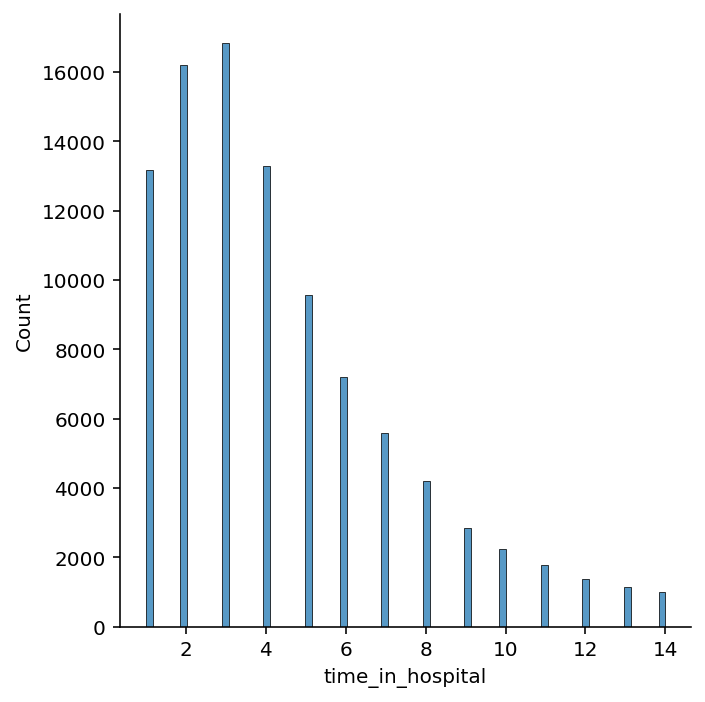

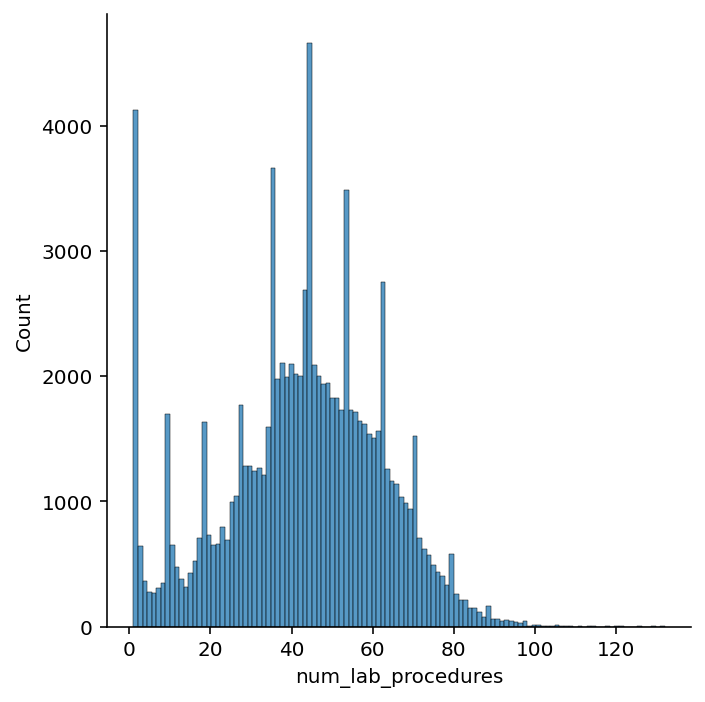

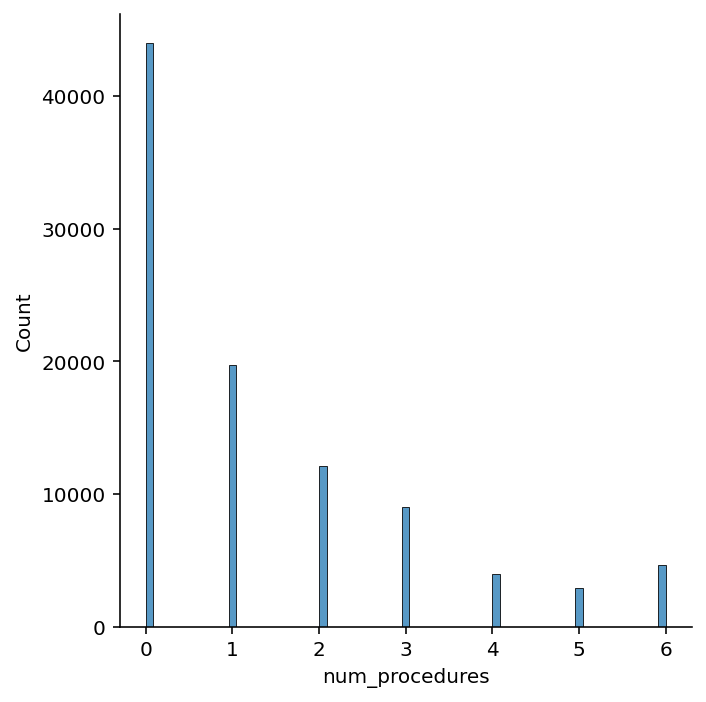

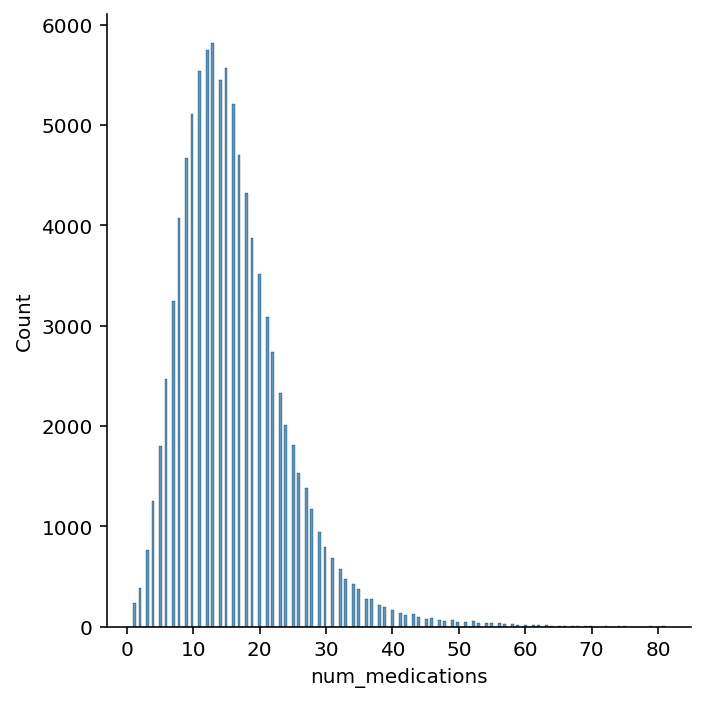

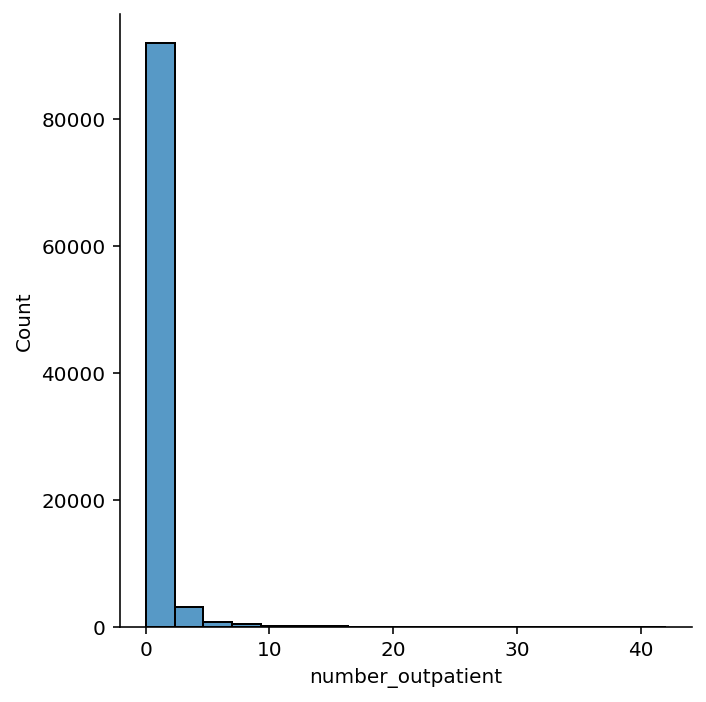

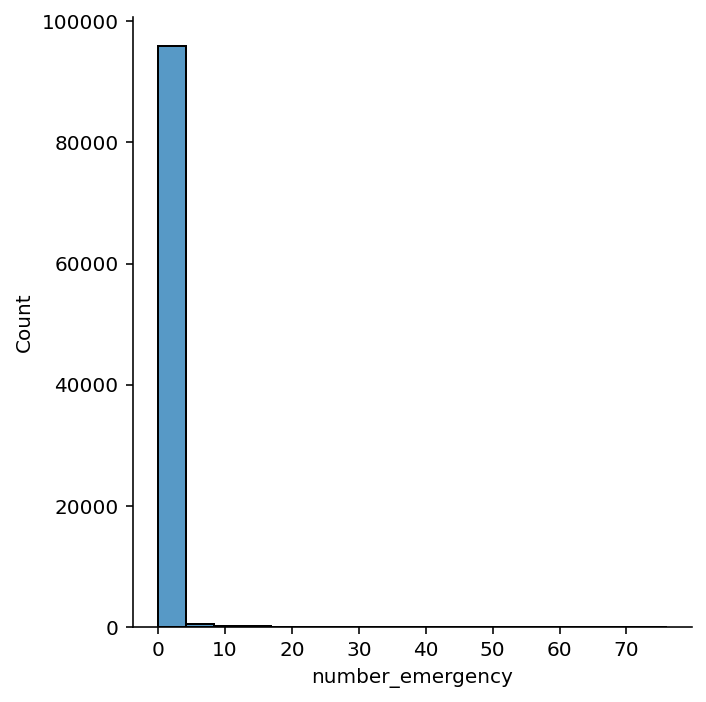

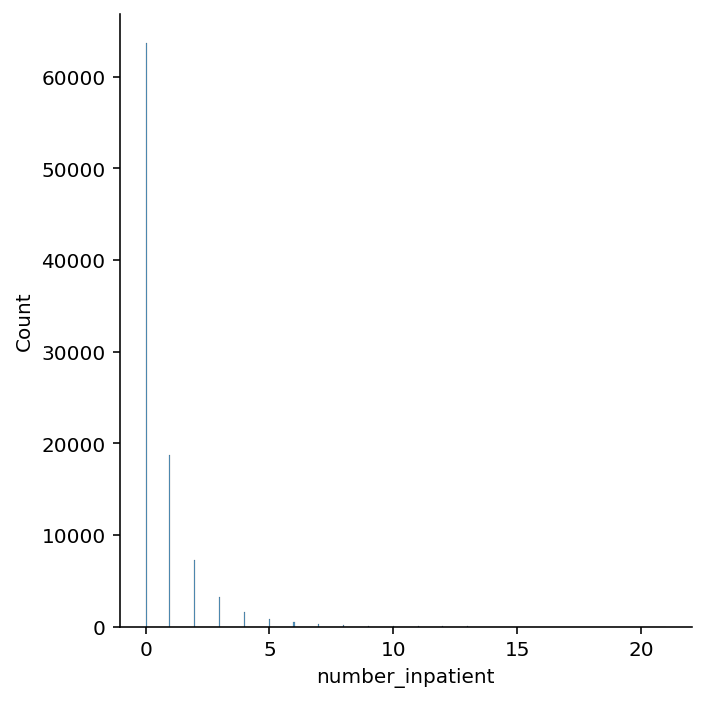

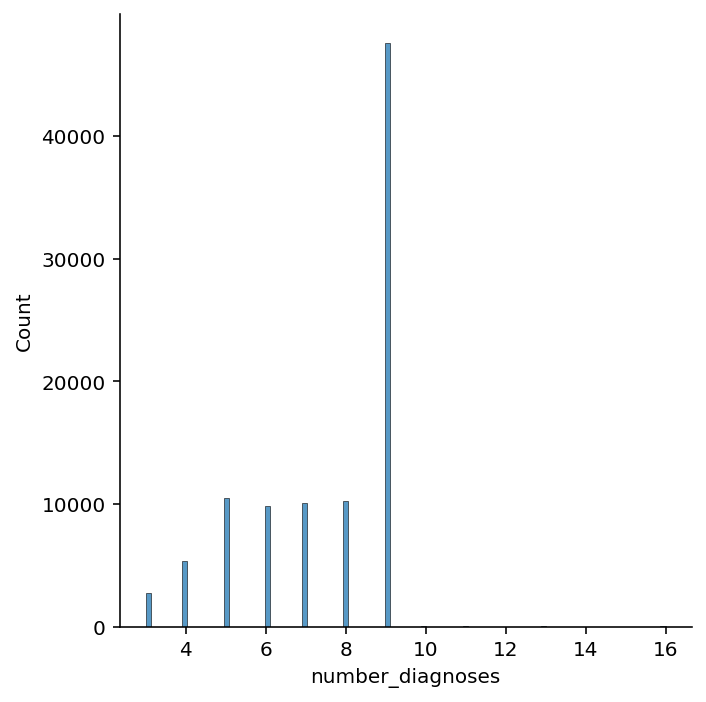

In [36]:
num_df = df[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']]

# self-distribution of numerical data
for col in num_df:
    sns.displot(df, x = col)

#### Correlation among Numerical Features
When we examine the correlation among the 8 numerical features, we observed a moderately high correlation between the` time_in_hopital` and the `num_medications` and `num_procedures`. These features all counts the instances of treatment that the patient received within the ten years.

In [0]:
num_df = df[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']]
sns.heatmap(num_df.corr(), cmap="YlGnBu")

### 1.2 Correlation between Features and Label


#### Correlation between Numerical Features and Label
We plotted the boxplot of numerical features for different label values. We observe from the cell bellow that most of the features show similar distribution around the mean. However, their mean show significant difference in `time_in_hospital`, `num_medications`, `num_impatient`, and `num_diagnosis`. 
Also, 'num_outpatients' and 'num_emergency' is extremely centered at 0, with a few outliers. That means these two features may have limited importance on the label. But we believe that these conditions, though rare, can significantly impact the readmission condition. So we keep these features for modeling.

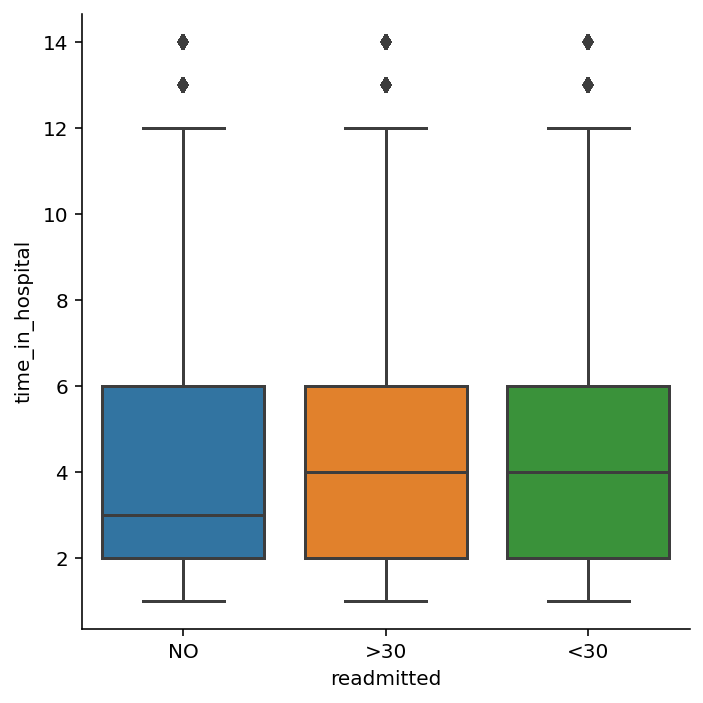

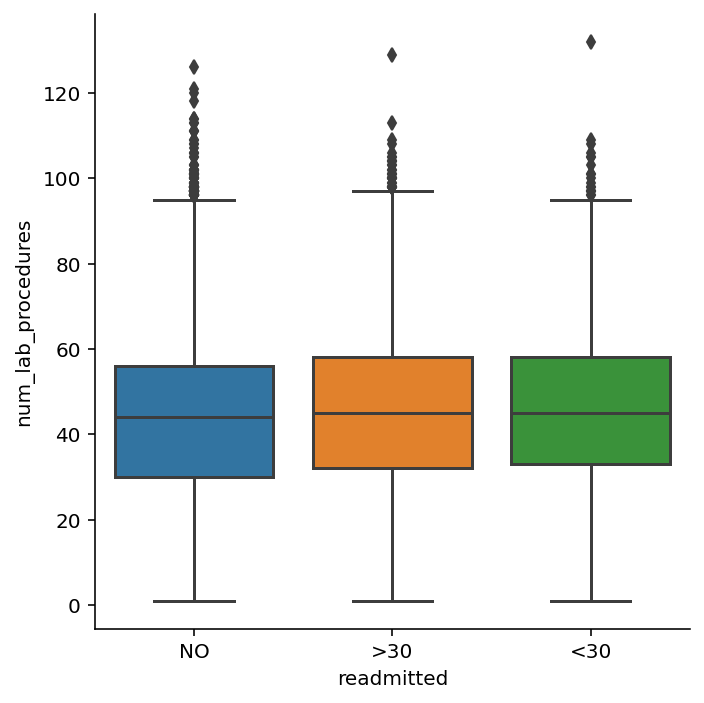

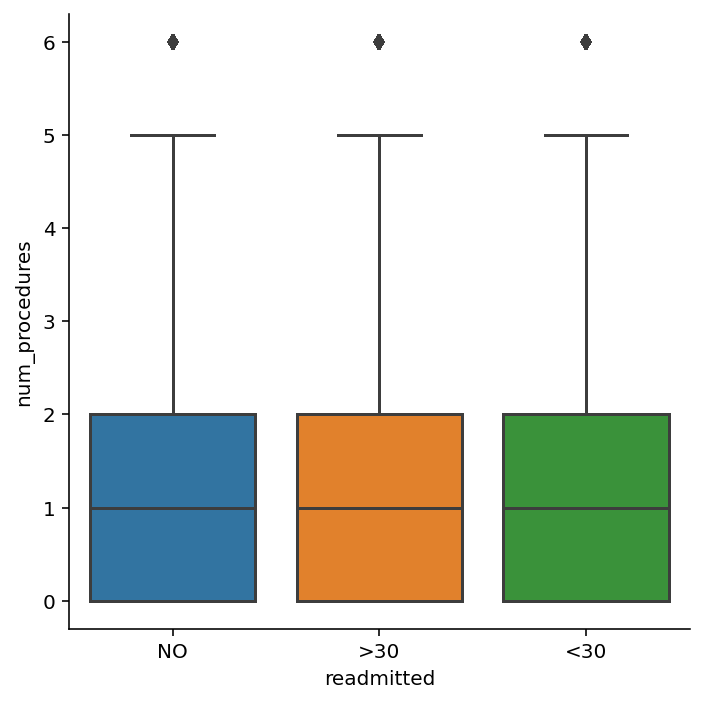

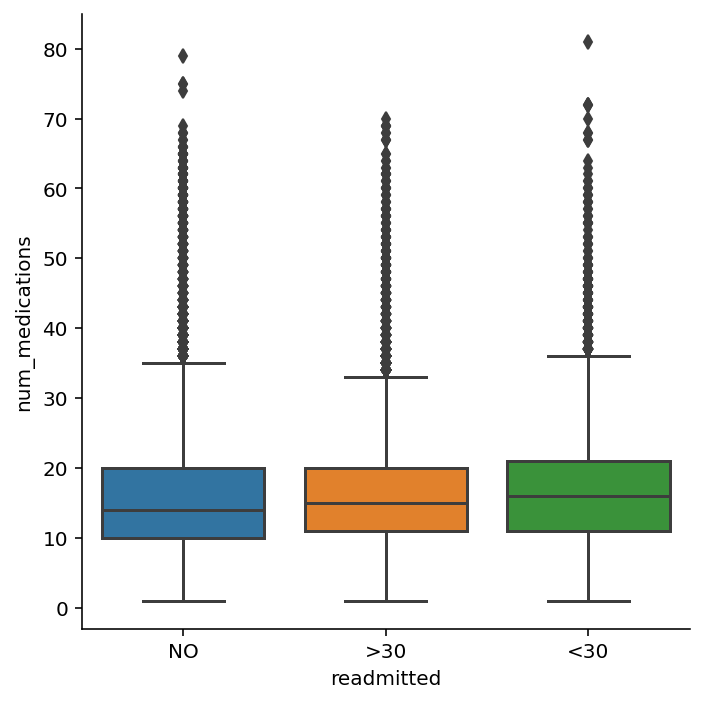

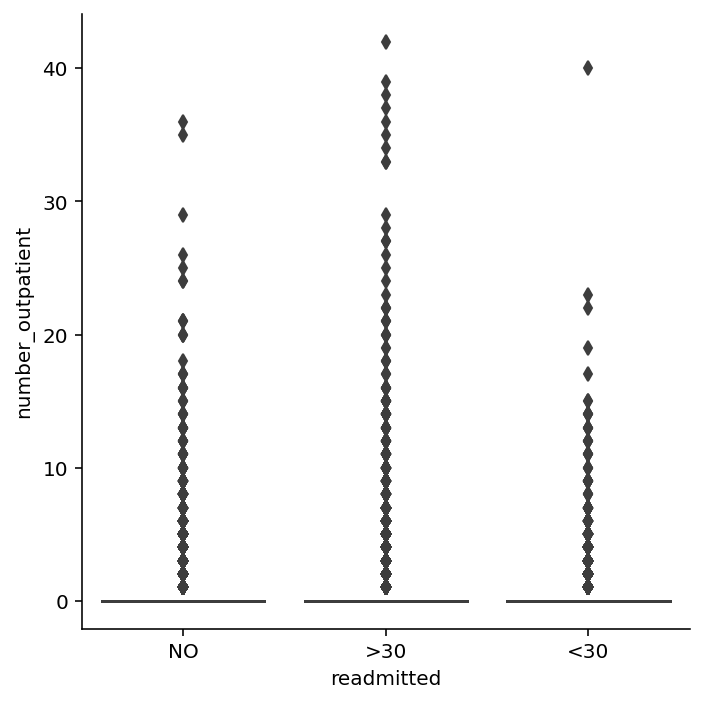

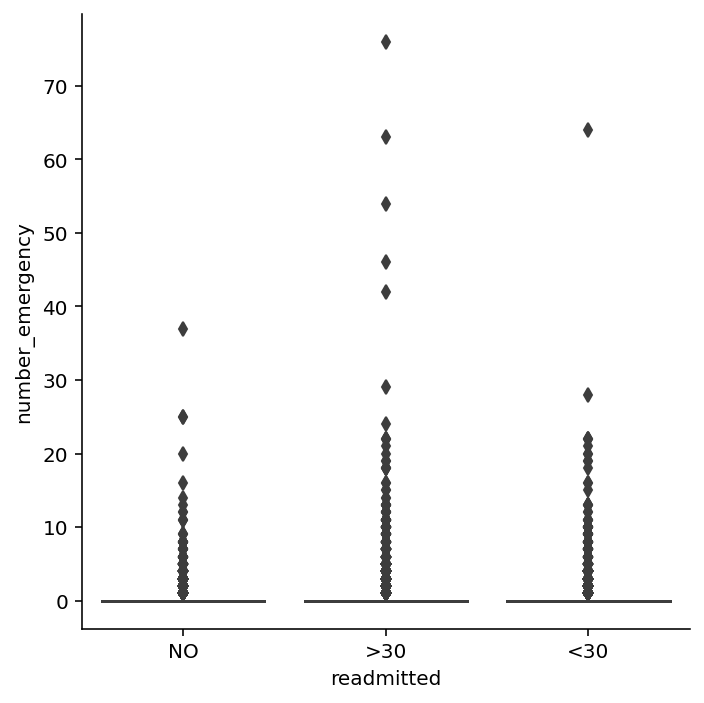

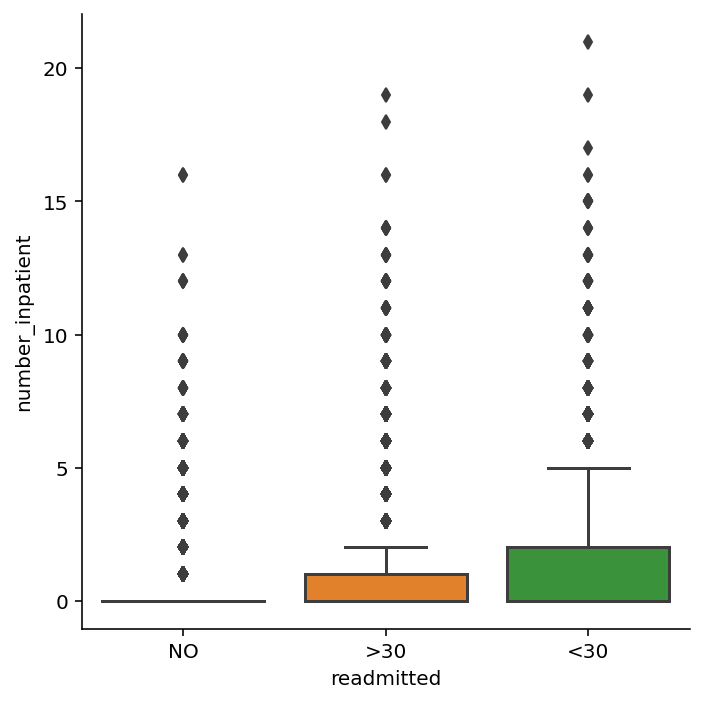

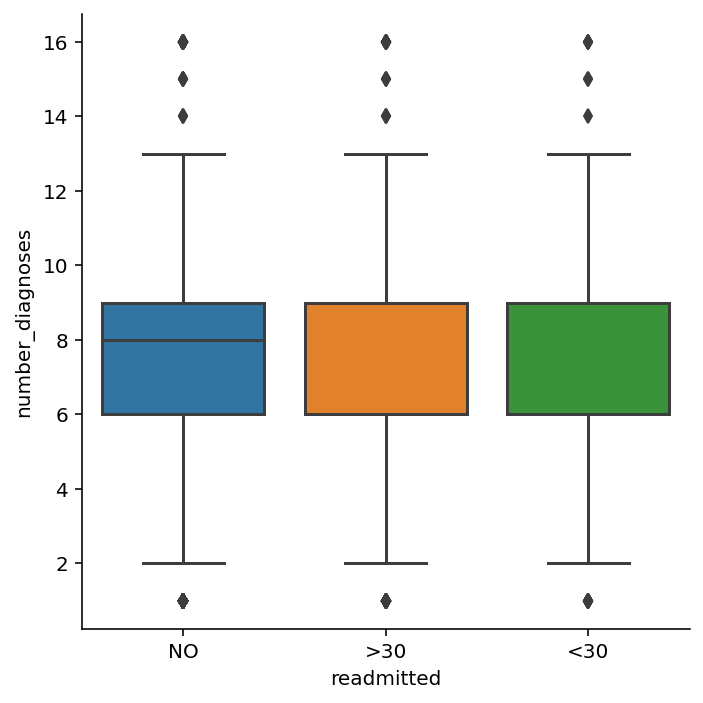

In [9]:
for col in num_df:
    sns.catplot(x="readmitted", y=col, kind="box", data=df)

#### Correlation between Categorical Features and Label

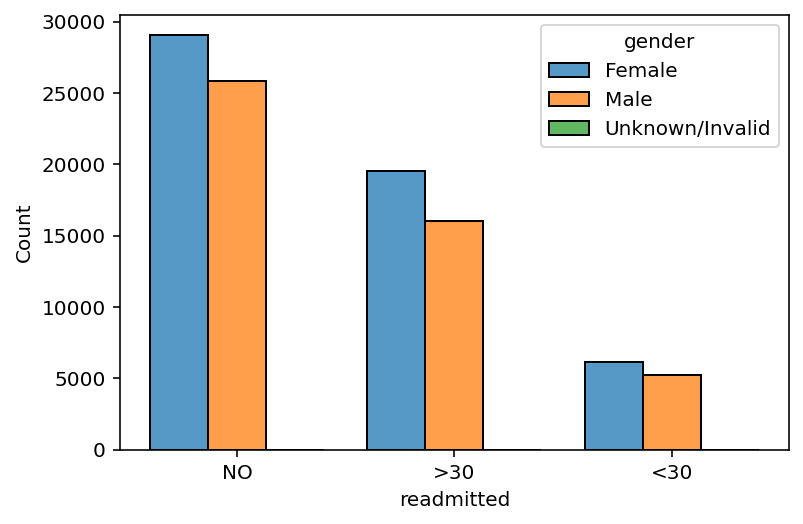

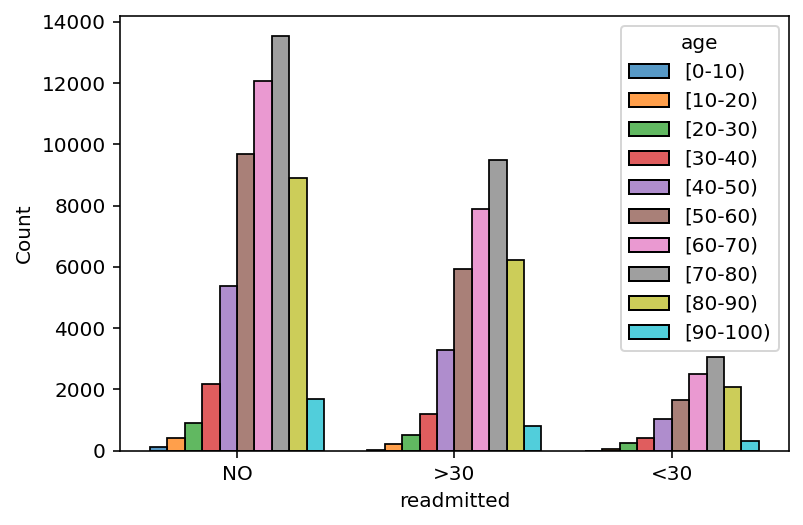

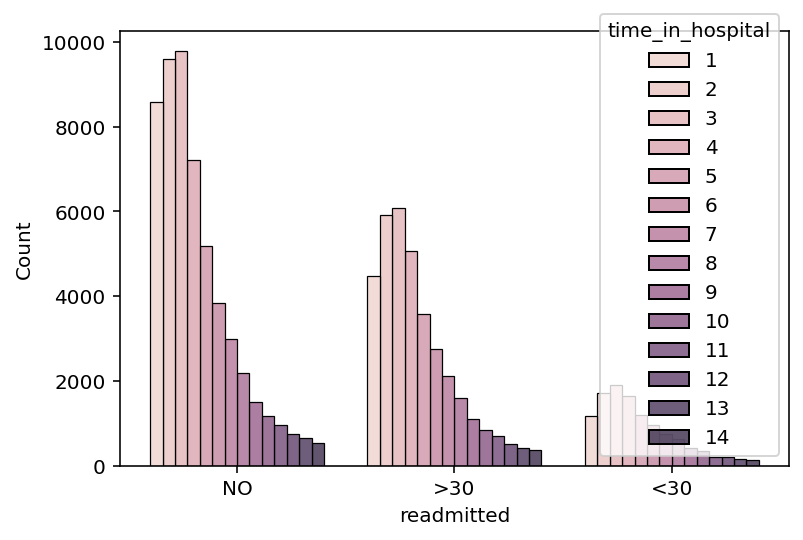

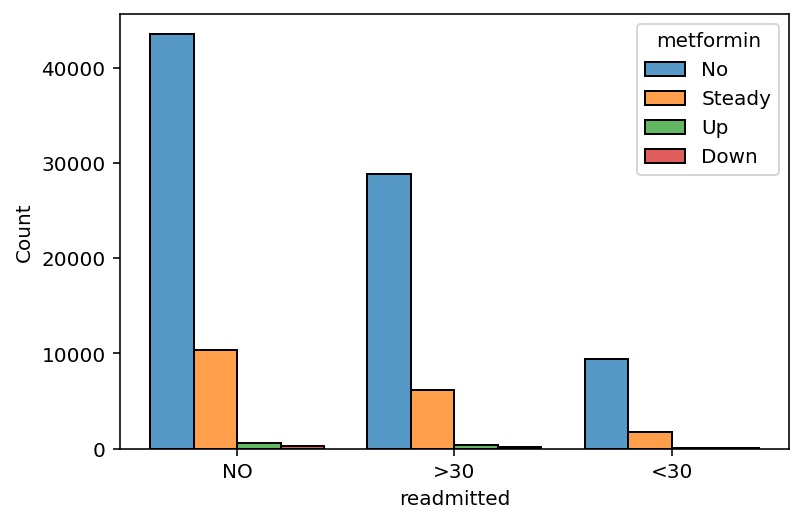

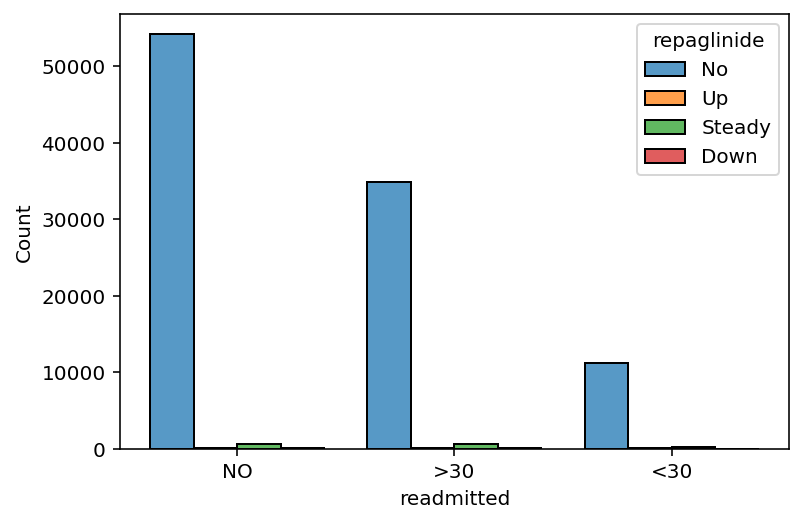

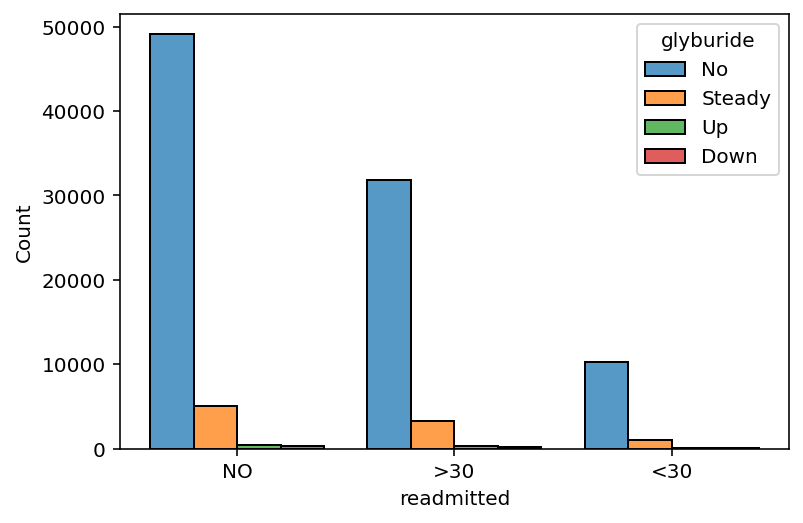

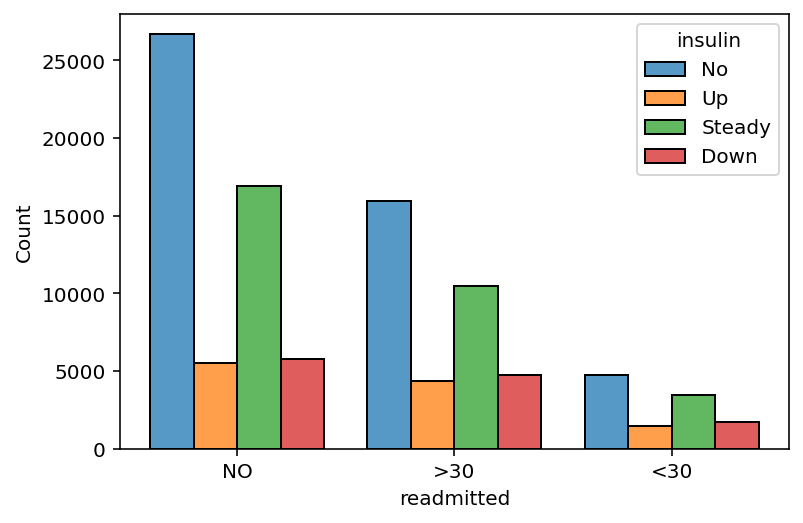

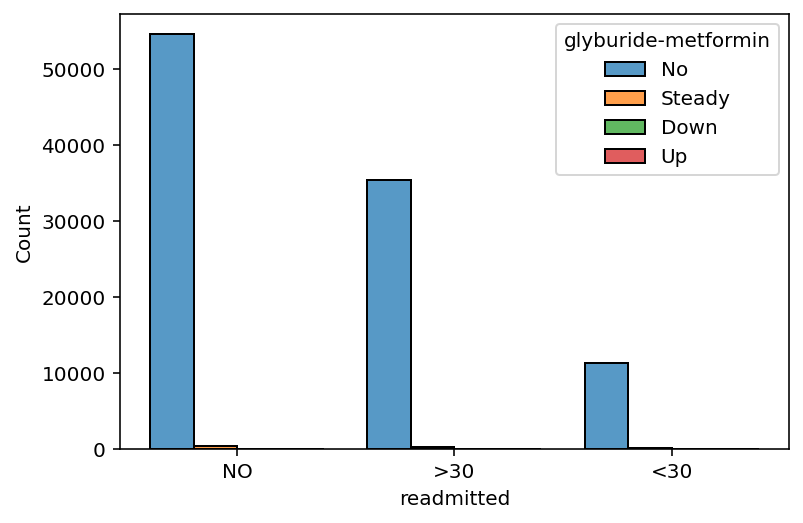

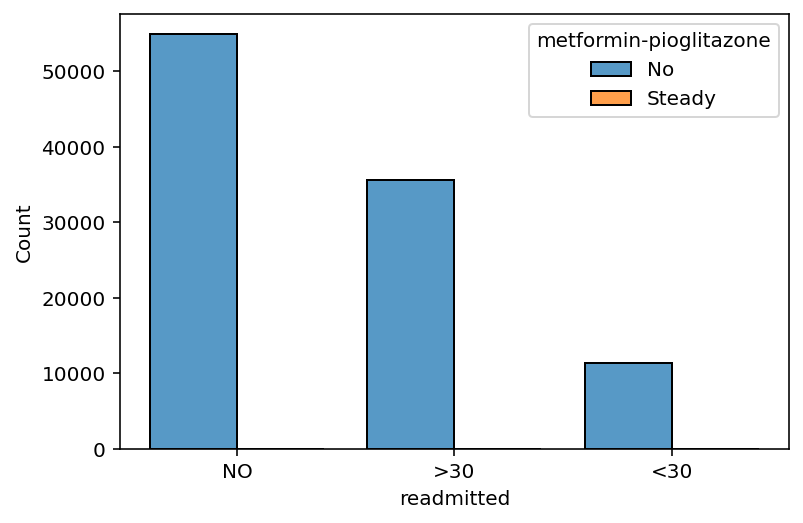

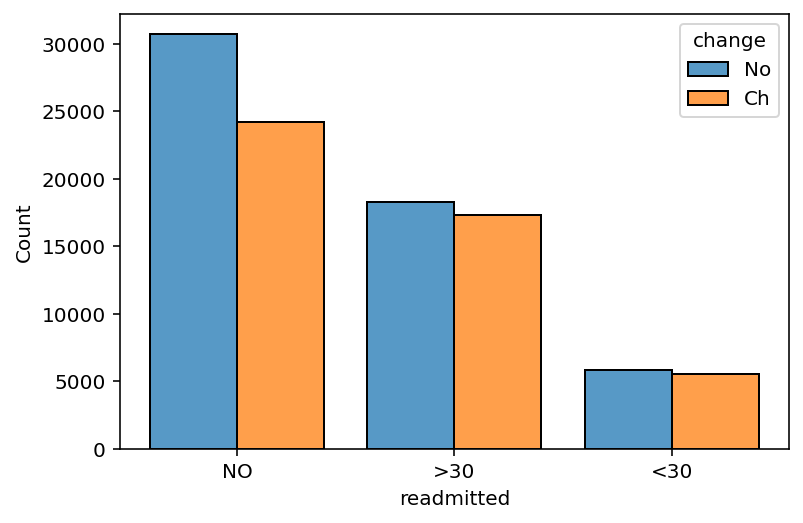

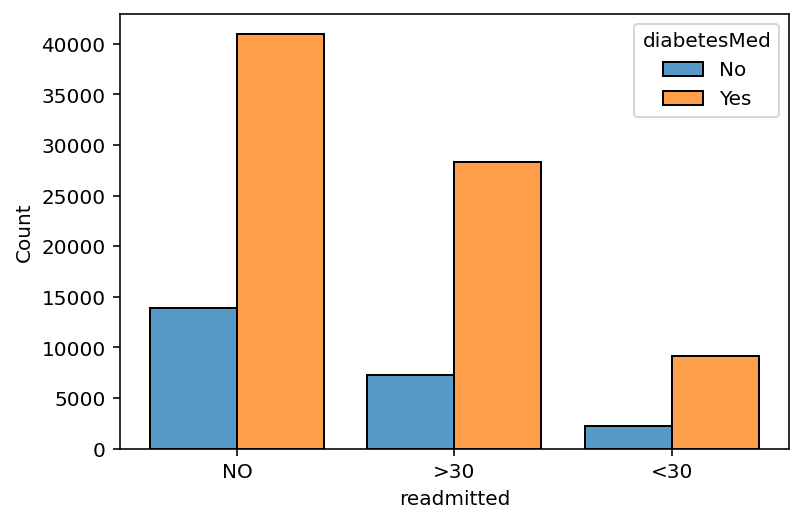

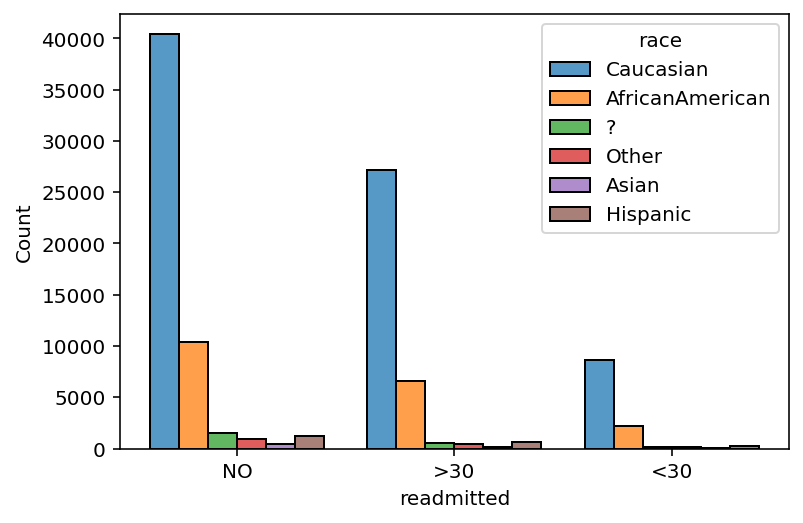

In [46]:
cat_df = df[['gender', 'age', 'time_in_hospital',
       'metformin', 'repaglinide', 'glyburide', 'insulin',
       'glyburide-metformin','metformin-pioglitazone', 'change', 'diabetesMed',
       'race']]
# correlation with readmission

for col in cat_df:
    sns.histplot(data=df, x="readmitted", hue=col, discrete = True, multiple="dodge", shrink=.8)
    plt.show()

In [0]:
df_survived=df[df['Survived']==1]
df_not_survive=df[df['Survived']==0]

age_bins=np.linspace(0,80,21)
Use np.histogram to generate histogram data

survived_hist=np.histogram(df_survived['Age'],bins=age_bins,range=(0,80))
not_survive_hist=np.histogram(df_not_survive['Age'],bins=age_bins,range=(0,80))
Calculate survival rate in each bin

surv_rates=survived_hist[0]/(survived_hist[0]+not_survive_hist[0])
Plot

plt.bar(age_bins[:-1],surv_rates,width=age_bins[1]-age_bins[0])
plt.xlabel('Age')
plt.ylabel('Survival Rate')

## 2. Data  Cleaning and Feature Engineering

We implement data cleaning to help us generate more accurate predictions. 

### 2.1 Missing Values
In order to prevent fields with missing values from influencing the result, we drop the columns with a large number of missing values, which were denoted as '?' or 'None' in the dataset. 

From the cell below, we observed that columns `weight`, `payer_code`, `medical_specialty`, `A1Cresult`, and `max_glu_serum` contains a large number of missing values; `citoglipton` and `examide` contains only one value, so we drop these features from the dataset.

In [11]:
# Missing values
for col in df.columns:
    if df[col].dtype == object:
         print(col,df[col][df[col] == '?'].count())

# Drop columns with high number of missing values and columns with only one value
df = df.drop(['weight', 'payer_code', 'medical_specialty'], axis=1)
df = df.drop(['citoglipton', 'examide'], axis=1)

race 2273
gender 0
age 0
weight 98569
payer_code 40256
medical_specialty 49949
diag_1 21
diag_2 358
diag_3 1423
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
examide 0
citoglipton 0
insulin 0
glyburide-metformin 0


glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0


For the columns where a small number of data is missing, we drop the rows instead of the columns. We dropped rows from `race`, `gender`, `diag_1`, `diag_2`, `diag_3`, and `discharge_disposition_id`.

In [13]:
# Data Cleaning

drop_idx = set(df['race'][df['race'] == '?'].index)
drop_idx = drop_idx.union(set(df[df['discharge_disposition_id'] == 11].index))
drop_idx = drop_idx.union(set(df['diag_1'][df['diag_1'] == '?'].index))
drop_idx = drop_idx.union(set(df['diag_2'][df['diag_2'] == '?'].index))
drop_idx = drop_idx.union(set(df['diag_3'][df['diag_3'] == '?'].index))
drop_idx = drop_idx.union(set(df['gender'][df['gender'] == 'Unknown/Invalid'].index))
new_idx = list(set(df.index) - set(drop_idx))
print('rows to be discarded: {}'.format(len(drop_idx)))

df = df.iloc[new_idx]
df.reset_index(inplace=True, drop=True)

rows to be discarded: 5320


### 2.2 Encode categories from diagnosis code

Next, we look at the columns `diag_1`, `diag_2` and `diag_3`, which represents the diagnosis of the patients according to the ICD-9 code. Based on the explanation in Wikipedia ( https://en.wikipedia.org/wiki/List_of_ICD-9_codes), we  encode all codes into 18 different categories of diseases. This step is crucial for model training as we cannot directly encode a categorical feature with 800 unique values.
Also, in order to avoid high dimensionality, we only use `diag_1_category` to train out model.


In [14]:
df['diag_1_category'] = df['diag_1']
df['diag_2_category'] = df['diag_2']
df['diag_3_category'] = df['diag_3']
diag_columns = ['diag_1', 'diag_2', 'diag_3']
for col in diag_columns: # external causes of injury and supplemental classification
    df.loc[df[col].str.contains('E'), col + '_category'] = 0
    df.loc[df[col].str.contains('V'), col + '_category'] = 0

diag_columns = ['diag_1_category', 'diag_2_category', 'diag_3_category']
for col in diag_columns:
    df[col] = df[col].astype(float)
for index, row in df.iterrows():
    for col in diag_columns:
        if 1 <= row[col] <= 139: df.loc[index, col] = 1 # infectious and parasitic diseases
        elif 140 <= row[col] <= 239: df.loc[index, col] = 2 # neoplasms
        elif 240 <= row[col] <= 279: df.loc[index, col] = 3 # endocrine, nutritional and metabolic diseases, and immunity disorders
        elif 280 <= row[col] <= 289: df.loc[index, col] = 4 # diseases of the blood and blood-forming organs
        elif 290 <= row[col] <= 319: df.loc[index, col] = 5 # mental disorders
        elif 320 <= row[col] <= 389: df.loc[index, col] = 6 # diseases of the nervous system and sense organs
        elif 390 <= row[col] <= 459: df.loc[index, col] = 7 # diseases of the circulatory system
        elif 460 <= row[col] <= 519: df.loc[index, col] = 8 # diseases of the respiratory system
        elif 520 <= row[col] <= 579: df.loc[index, col] = 9 # diseases of the digestive system
        elif 580 <= row[col] <= 629: df.loc[index, col] = 10 # diseases of the genitourinary system
        elif 630 <= row[col] <= 679: df.loc[index, col] = 11 # complications of pregnancy, childbirth, and the puerperium
        elif 680 <= row[col] <= 709: df.loc[index, col] = 12 # diseases of the skin and subcutaneous tissue
        elif 710 <= row[col] <= 739: df.loc[index, col] = 13 # diseases of the musculoskeletal system and connective tissue
        elif 740 <= row[col] <= 759: df.loc[index, col] = 14 # congenital anomalies
        elif 760 <= row[col] <= 779: df.loc[index, col] = 15 # certain conditions originating in the perinatal period
        elif 780 <= row[col] <= 799: df.loc[index, col] = 16 # symptoms, signs, and ill-defined conditions
        elif 800 <= row[col] <= 999: df.loc[index, col] = 17 # injury and poisoning


### 2.3 Encode feature of medication
In the original dataset, the use of medication by an individual is represented using the lables "Steady", "Up", and "Down", with majority of them labelling "No". We decided to group them into a binary variable with 0 as not using medication and 1 as using medication by combining "Steady", "Up", and "Down" as one category, thereby emphasizing the impact of the presence of these medications in the patient's readmission conditions and ignoring whether the patient has higher or lower suggested medication intake.

In [16]:
medical_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']
for col in medical_cols:
    df.loc[df[col] == 'No', col] = 0
    df.loc[df[col] == 'Steady', col] = 1
    df.loc[df[col] == 'Up', col] = 1
    df.loc[df[col] == 'Down', col] = 1
    df[col] = df[col].astype('category')

### 2.4 Encoding Target Label: Readmission 
In the original dataset, re-admission data is divided into three categories: 1) not readmitted, 2) re-admitted within 30 days, and 3) readmitted after 30 days. In our project, we specifically examine 30-day re-admission because it is the most relevant to hospital treatment and decision and have been used in state law to gauge the effectiveness of the treatment of a healthcare system.. We encode `readmitted` as 1 if patients are readmitted in less than 30 days and 0 if the patients are readmitted after 30 days or even no longer require readmission.

In [0]:
# Readmitted: process into two categories
df.loc[df['readmitted'] == 'NO', 'readmitted'] = 0
df.loc[df['readmitted'] == '>30', 'readmitted'] = 0 # TODO
df.loc[df['readmitted'] == '<30', 'readmitted'] = 1
df['readmitted'] = df['readmitted'].astype('int64')
print(df['readmitted'].value_counts())

### 2.4 Early Re-admission Rate between Races
Based on the two graphs below, we observe that the most common races in the dataset is  Caucasian and African American.
We further plot the readmission rates for different races and notice that they are approximately the same.

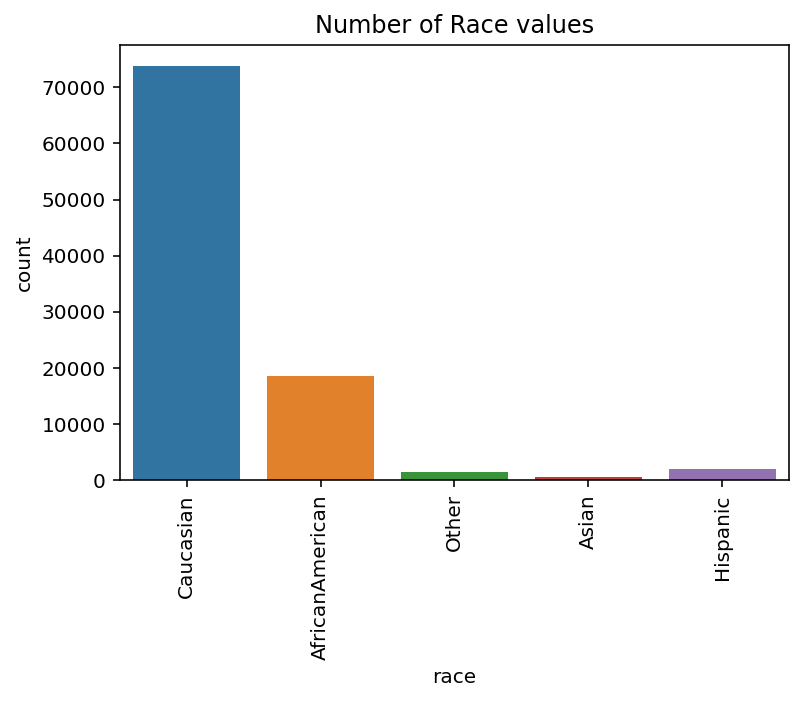

Proportion of Race
Caucasian          76.555793
AfricanAmerican    19.243929
Hispanic            2.043631
Other               1.516911
Asian               0.639736
Name: race, dtype: float64


In [23]:
sns.countplot(x=df['race'], data = df)
plt.xticks(rotation=90)
plt.title("Number of Race values")
plt.show()

print("Proportion of Race")
print(df.race.value_counts(normalize = True)*100)

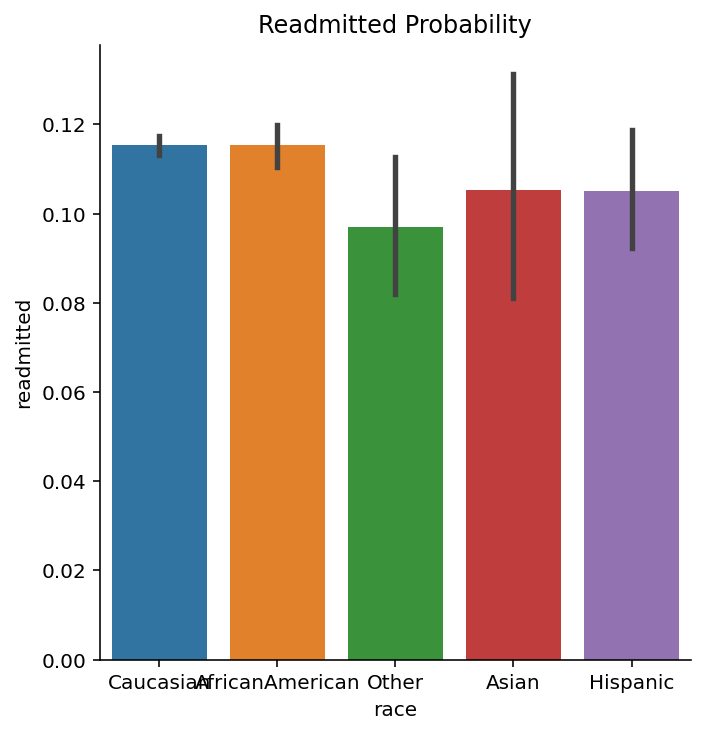

In [24]:
sns.catplot(x = "race", y = "readmitted",
            data = df, kind = "bar", height= 5)
plt.title("Readmitted Probability")
plt.show()

We format the race data using on-hot encoding for the race data to format

In [32]:
# race: one hot encoding
df = pd.get_dummies(df, columns = ['race'])

The rate of re-admission based on age shows more variability. We see that patients with age 20-30 is most likely to be readmitted, where as patients of age 10-20, 100-101, and 50-60 is less likely to be re-admitted. This may be due to the different attention level from medical professionals based on different age groups.

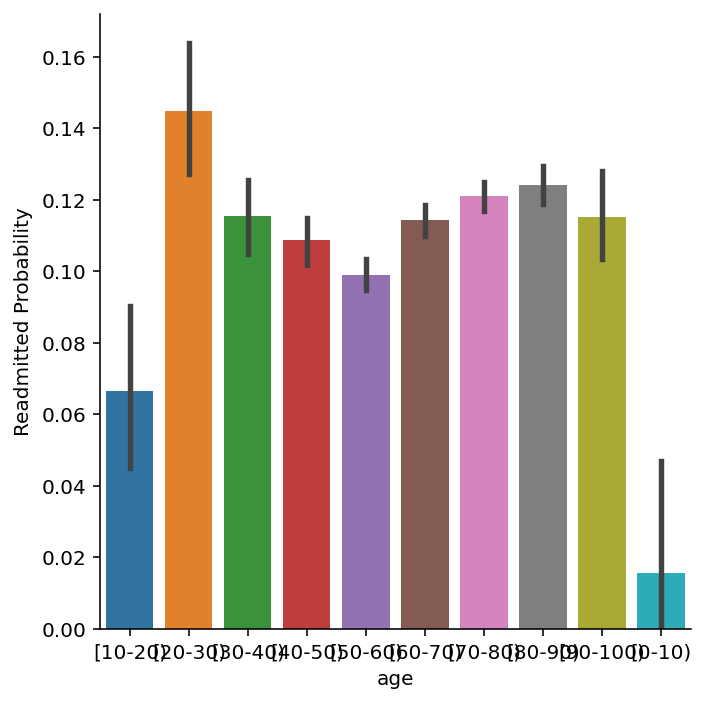

In [25]:
g = sns.catplot(x = "age", y = "readmitted", data = df, 
                   kind = "bar", height = 5)
g.set_ylabels("Readmitted Probability")
plt.show()

### Preprocess race \(one\-hot\), gender \(binary\), age \(covert to numerical\), change \(binary\), diabetesMed \(binary\)



In [26]:
# Change age to numerical
df.loc[df['age'] == '[0-10)', 'age'] = 0
df.loc[df['age'] == '[10-20)', 'age'] = 1
df.loc[df['age'] == '[20-30)', 'age'] = 2
df.loc[df['age'] == '[30-40)', 'age'] = 3
df.loc[df['age'] == '[40-50)', 'age'] = 4
df.loc[df['age'] == '[50-60)', 'age'] = 5
df.loc[df['age'] == '[60-70)', 'age'] = 6
df.loc[df['age'] == '[70-80)', 'age'] = 7
df.loc[df['age'] == '[80-90)', 'age'] = 8
df.loc[df['age'] == '[90-100)', 'age'] = 9

# Change dtype to numerical
df['age'] = df['age'].astype('int64')

In [27]:
df.loc[df['gender'] == 'Male', 'gender'] = 0
df.loc[df['gender'] == 'Female', 'gender'] = 1
df['gender'] = df['gender'].astype('int64')

In [28]:
# Binary encoding
df.loc[df['change'] == 'No', 'change'] = 0
df.loc[df['change'] == 'Ch', 'change'] = 1
df['change'] = df['change'].astype('int64')
df.loc[df['diabetesMed'] == 'Yes', 'diabetesMed'] = 1
df.loc[df['diabetesMed'] == 'No', 'diabetesMed'] = 0
df['diabetesMed'] = df['diabetesMed'].astype('int64')

Finally, we generate one-hot encoding for the non-binary categorical features (races, diagnosis categories) and use them as our training features.

In [33]:
# one hot encoding diag1
df['diag_1_category_copy'] = df['diag_1_category']
df = pd.get_dummies(df, columns = ['diag_1_category'])
df['diag_1_category'] = df['diag_1_category_copy']
df.drop(['diag_1_category_copy'], axis = 1, inplace = True)
# Avoid too many dimensions
# df.drop(['diag_2_category', 'diag_3_category'], axis = 1, inplace = True)

In [107]:
X_col = [
       'gender', 'age', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed',
       'race_AfricanAmerican',
       'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other','diag_1_category_0.0',
       'diag_1_category_1.0', 'diag_1_category_2.0', 'diag_1_category_3.0',
       'diag_1_category_4.0', 'diag_1_category_5.0', 'diag_1_category_6.0',
       'diag_1_category_7.0', 'diag_1_category_8.0', 'diag_1_category_9.0',
       'diag_1_category_10.0', 'diag_1_category_11.0', 'diag_1_category_12.0',
       'diag_1_category_13.0', 'diag_1_category_14.0', 'diag_1_category_16.0',
       'diag_1_category_17.0'
]
print('Number of featuers used: {}'.format(len(X_cols)))
y_col = 'readmitted'

Number of featuers used: 55


In [108]:
X_final = df[X_col]
y_final = df[y_col]
print(X_final.shape)
print(y_final.shape)

(96446, 55)
(96446,)


## 3. Machine Learning Model Training




### 3.1 Stratified Shuffle Split



In [141]:
from sklearn.model_selection import StratifiedShuffleSplit
sss=StratifiedShuffleSplit(test_size=0.2,random_state=42)

In [142]:
for train_index, test_index in sss.split(X_final,y_final):
    X_train,X_test=X_final.iloc[train_index],X_final.iloc[test_index]
    y_train,y_test=y_final[train_index],y_final[test_index]

In [111]:
len(X_train), len(y_train)

(86801, 86801)

In [143]:
len(X_test), len(y_test)

(19290, 19290)

In [144]:
len(y_train[y_train==1])/len(y_train), len(y_test[y_test==1])/len(y_test)

(0.11474156254860284, 0.11472265422498704)

### 3.2 Balancing Dataset - SMOTE
We notice a high class imbalance in the two categories of readmission. In particular, most of the training data are identified as not admitted according to the 30-day readmission standard. Therefore, we use SMOTE to oversample the training set and use a training set that has balanced labels. 

In [147]:
from imblearn.over_sampling import SMOTENC

In [156]:
sm = SMOTENC(random_state=42, categorical_features=[0,1,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54])

In [157]:
X_train, y_train = sm.fit_resample(X_train, y_train)

In [158]:
len(X_train), len(y_train)

(136606, 136606)

In [159]:
len(y_train[y_train==1])/len(y_train), len(y_test[y_test==1])/len(y_test)

(0.5, 0.11472265422498704)

In [160]:
X_train=X_train.reset_index()
X_train=X_train.drop(['index'],axis=1)
X_test=X_test.reset_index()
X_test=X_test.drop(['index'],axis=1)

In [161]:
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
pd.DataFrame(y_train).to_csv('y_train.csv')
pd.DataFrame(y_test).to_csv('y_test.csv')

### 3.3 Logistic Regression
Logistic Regression is the baseline model we use. It is a simple classification model that predicts the risk of binary classes. If the predicted probability of readmission is more than $50\%$, the model classifies the instance into the positive y class and vice versa.

Normally, a vectorized form of linear regression is simply $h_{\theta}(x)={\theta}^{T}x$. But a linear model would output a continuous range of values. To transform the continuous range into a boundary of $(0,1)$ for classification problems, we can utilize the S-shaped sigmoid function: $\sigma(z)=\frac{1}{1+e^{-z}}$. By combining the sigmoid function with the linear regression form we can obtain the logistic function: $h_{\theta}(x)=\sigma({\theta}^{T}x)=\frac{1}{1+e^{(-{\theta}^{T}x)}}$. 

Furthermore, there is a loss function associated with the logistic function, namely $J(\theta)=-\frac{1}{m}\sum_{i=1}^{m}(y^{(i)}\log (h_{\theta}(x^{(i)}))+(1-y^{(i)})\log (1-h_{\theta}(x^{(i)})))$, where $y^{(i)}$ denotes the labeled value. The $\log$ function transforms a high value of $h_{\theta}(x^{(i)})$ (close to 1) into a relatively lower absolute value. Therefore, when the $y$ label is 1 and when the $h_{\theta}$ value is close to 1, the loss is small. Similarly, when the $y$ label is 0 and when the $h_{\theta}$ value is close to 0, the loss is small. Since the cost function is convex, gradient descent can be used to find the global minimum, given the learning rate is small and the number of iterations is sufficient enough for the loss function to converge. This is done by continuously updating the coefficient $\displaystyle{\theta_j := \theta_j-\alpha \frac{\partial}{\partial \theta_j}J(\theta)}$ until convergence.

In sklearn, we can simply import LogisticRegression to employ the model.

In [162]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [188]:
cv_LR_params={'C':[1, 10, 50],#smaller values specify stronger regularization.
             'max_iter':[50, 100, 200], #how many rounds...
             'tol':[1e-6] #lower value permits the algorithm to fully converge
             }
ind_LR_params={'penalty':'l2','random_state':42,'solver':'saga','n_jobs':-1}
optimized_LR=GridSearchCV(LogisticRegression(**ind_LR_params),
                         cv_LR_params,scoring='f1',cv=5,n_jobs=-1, verbose=10)

In [189]:
optimized_LR.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=LogisticRegression(n_jobs=-1, random_state=42,
                                          solver='saga'),
             n_jobs=-1,
             param_grid={'C': [1, 10, 50], 'max_iter': [50, 100, 200],
                         'tol': [1e-06]},
             scoring='f1', verbose=10)

In [190]:
optimized_LR.best_params_

{'C': 10, 'max_iter': 200, 'tol': 1e-06}

In [191]:
optimized_LR.cv_results_

{'mean_fit_time': array([ 5.73031807, 11.61835246, 22.5598465 ,  5.44227929, 11.09812212,
        24.79605498,  6.11053991, 11.90754151, 21.13246765]),
 'std_fit_time': array([0.60650807, 1.29291886, 2.56360074, 0.63358189, 1.2329998 ,
        0.17390027, 0.47980724, 1.25942305, 2.57346462]),
 'mean_score_time': array([0.02913961, 0.02572823, 0.02807417, 0.02337394, 0.02543206,
        0.03083549, 0.02722726, 0.02522879, 0.02789712]),
 'std_score_time': array([0.00353853, 0.00321345, 0.00269592, 0.00072622, 0.00346263,
        0.00946536, 0.00376307, 0.00326643, 0.00489364]),
 'param_C': masked_array(data=[1, 1, 1, 10, 10, 10, 50, 50, 50],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_max_iter': masked_array(data=[50, 100, 200, 50, 100, 200, 50, 100, 200],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fil

In [193]:
#best hyperparameters.
final_LR=LogisticRegression(penalty='l2',random_state=42,solver='saga',C=10,max_iter=200,tol=1e-6,n_jobs=-1)

In [194]:
final_LR.fit(X_train,y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=10, max_iter=200, n_jobs=-1, random_state=42,
                   solver='saga', tol=1e-06)

In [171]:
final_LR.coef_

array([[-2.05365071e-02,  1.48896539e-01, -3.38151007e-02,
         7.25379665e-04, -1.12750611e-01,  2.02270825e-02,
        -1.43498616e-01,  3.94051221e-02,  1.70277786e-01,
        -3.05493484e-03, -1.25661448e+00, -1.81139115e+00,
        -1.31556588e+00, -6.26926748e-01, -2.02168820e+00,
        -8.25199210e-03, -1.60689398e+00, -1.81097845e+00,
        -2.18388543e-01, -1.64636346e+00, -1.63834757e+00,
        -7.03989116e-01, -1.50484528e-01, -1.85238760e-02,
        -2.53029778e-01, -9.31947146e-01, -1.45275002e+00,
        -6.99586148e-02, -1.26570217e-02,  0.00000000e+00,
        -1.25738218e-03,  6.39000000e-01,  1.51835893e+00,
        -3.66527526e-01, -6.38452079e-01,  1.67748246e-01,
        -7.77593342e-01, -9.95072563e-01, -3.93970434e+00,
        -4.59458323e+00, -4.56673217e+00, -3.93366125e+00,
        -3.87367197e+00, -4.18950646e+00, -4.15671302e+00,
        -3.12829036e+00, -4.28888591e+00, -4.34493908e+00,
        -4.58390590e+00, -3.33481759e+00, -4.65109814e+0

#### Performance



In [54]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, roc_curve, roc_auc_score

In [196]:
cross_val_score(final_LR,X_train,y_train,scoring="f1",n_jobs=-1,cv=10)
f1_LR = cross_val_score
f1_LR

<function sklearn.model_selection._validation.cross_val_score(estimator, X, y=None, *, groups=None, scoring=None, cv=None, n_jobs=None, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', error_score=nan)>

In [197]:
y_pred_LR=final_LR.predict(X_test)

In [198]:
accuracy_score(y_test,y_pred_LR)

0.8191290824261275

In [199]:
precision_score(y_test,y_pred_LR)

0.16171792152704137

In [200]:
recall_score(y_test,y_pred_LR)

0.13782196113872572

In [201]:
f1_score(y_test,y_pred_LR)

0.14881678458160527

In [62]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--') ##
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

[CV 2/5; 1/9] START C=1, max_iter=50, tol=1e-06.................................
[CV 2/5; 1/9] END ..C=1, max_iter=50, tol=1e-06;, score=0.875 total time=   4.9s
[CV 4/5; 1/9] START C=1, max_iter=50, tol=1e-06.................................
[CV 4/5; 1/9] END ..C=1, max_iter=50, tol=1e-06;, score=0.869 total time=   5.5s
[CV 3/5; 2/9] START C=1, max_iter=100, tol=1e-06................................
[CV 3/5; 2/9] END .C=1, max_iter=100, tol=1e-06;, score=0.878 total time=  10.8s
[CV 1/5; 3/9] START C=1, max_iter=200, tol=1e-06................................
[CV 1/5; 3/9] END .C=1, max_iter=200, tol=1e-06;, score=0.647 total time=  20.5s
[CV 4/5; 3/9] START C=1, max_iter=200, tol=1e-06................................
[CV 4/5; 3/9] END .C=1, max_iter=200, tol=1e-06;, score=0.885 total time=  20.7s
[CV 4/5; 4/9] START C=10, max_iter=50, tol=1e-06................................
[CV 4/5; 4/9] END .C=10, max_iter=50, tol=1e-06;, score=0.869 total time=   5.5s
[CV 1/5; 5/9] START C=10, ma

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means 

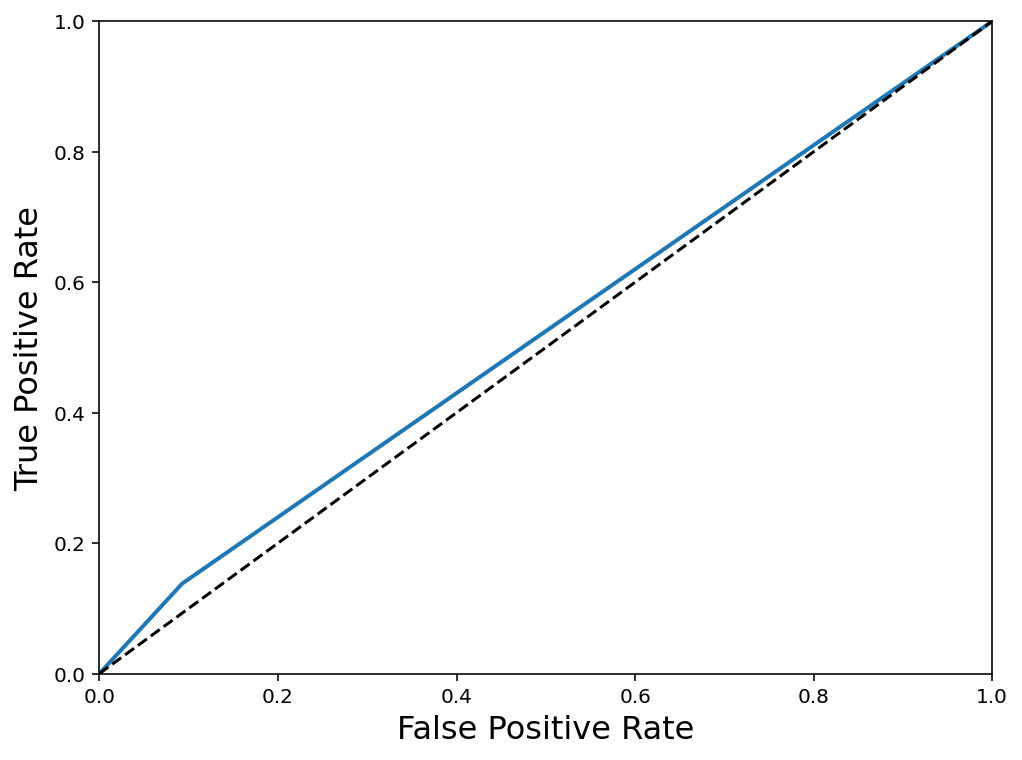

In [203]:
fpr,tpr,thresholds=roc_curve(y_test,y_pred_LR)

plt.figure(figsize=(8,6))
plot_roc_curve(fpr,tpr)

plt.show()

In [204]:
roc_auc_score(y_test,y_pred_LR)

0.5226206485438315

###  3.4 Random Forest
Random Forest is our second machine learning model and has been quite popularly used in recent years. The ensemble model is bagging of Decision Trees and aggregates the independent weak learners together into a strong one. 

Firstly, Decision Tree is a basic model that uses the tree structure to construct a predictor. It splits the data set into two subsets at every node, depending on a specific feature and it keeps splitting until it reaches the leaf node. One can predict the target value by following from the root down to a leaf node. A decision tree also has a loss function for a feature $k$ and its threshold $t_k$: $J(k, t_k)=\frac{m_{left}}{m}G_{left}+\frac{m_{right}}{m}G_{right}$. The $m_{left}$ and $m_{right}$ are simply the number of instances in the left/right subset. And $G_{left}$, $G_{right}$ are the impurity of the left/right subset, i.e. the proportion of the misclassified instances. The decision tree greedily searches for the optimum split at the top level, one that reduces the loss function the most. Furthermore, Gini-index is $G_i=1-\sum_{k=1}^{n}({p_{i,k}}^2)$, where ${p_{i,k}}$ is the ratio of class $k$ instances among all instances in the $i$\textsuperscript{th} node. The Gini-index is equal to 0 if the instances are perfectly classified. Similar to the process above, the decision tree algorithm selects a feature and threshold to split, such that the Gini-index is decreased the most. By default, sklearn uses Gini-index for the splitting criterion. 

Although a Decision Tree is simple, intuitive, and easy-to-explain, it is not sophisticated enough to handle complex data sets and it is very unstable. That is why we use ensemble models to turn a weak learner into a strong one. 

Random Forest trains several Decision Trees on sub-samples of the whole data set. It selects each sub-sample by random sampling with replacement - a process called bootstrap. And by aggregating each independent Decision Tree output together through averaging the predicted probability, we can usually get a higher predictive accuracy and reduce the possibility of over-fitting. Random Forest is a voting classifier that utilizes the principle of ``wisdom of the crowd" to maximize model performance. Therefore, we would expect Random Forest classifiers to perform better than our baseline model. Also, Random Forest trains independent trees in parallel and can utilize all the CPU cores to make the process faster. 

In sklearn, we simple import RandomForestClassifier to employ the model.



In [205]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [206]:
cv_params_RF={
    'n_estimators':randint(low=5,high=50),
    'max_depth':randint(low=5,high=30),
    'min_samples_split':randint(low=5, high=20),
    'min_samples_leaf':randint(low=3,high=10),
    'max_features':randint(low=5,high=55), #total of 
    #'min_weight_fraction_leaf': It's a bit redundant with min_samples_leaf if the sample weights are not provided,
    # and since the data set is already balanced, no need ofr class_weight
    'min_impurity_decrease':[0,0.0001,0.0005,0.001,0.005,0.01]
    #'max_leaf_nodes': this is the same as max_depth no use...
 }

ind_params_RF={'n_jobs':-1,'random_state':42}
RSCV_RF=RandomizedSearchCV(RandomForestClassifier(**ind_params_RF),
                           cv_params_RF,n_iter=50,cv=5,scoring='accuracy',n_jobs=-1, verbose=10)
RSCV_RF.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[CV 1/5; 1/50] START max_depth=24, max_features=36, min_impurity_decrease=0.001, min_samples_leaf=9, min_samples_split=19, n_estimators=13
[CV 1/5; 1/50] END max_depth=24, max_features=36, min_impurity_decrease=0.001, min_samples_leaf=9, min_samples_split=19, n_estimators=13;, score=0.633 total time=   5.6s
[CV 1/5; 2/50] START max_depth=14, max_features=20, min_impurity_decrease=0, min_samples_leaf=3, min_samples_split=12, n_estimators=44
[CV 1/5; 2/50] END max_depth=14, max_features=20, min_impurity_decrease=0, min_samples_leaf=3, min_samples_split=12, n_estimators=44;, score=0.646 total time=  10.7s
[CV 4/5; 2/50] START max_depth=14, max_features=20, min_impurity_decrease=0, min_samples_leaf=3, min_samples_split=12, n_estimators=44
[CV 4/5; 2/50] END max_depth=14, max_features=20, min_impurity_decrease=0, min_samples_leaf=3, min_samples_split=12, n_estimators=44;, score=0.863 total time=  11.5s
[CV 2/5; 3/50] START max_depth=17, max_features=33, min_impurity_decrease=0.01, min_sampl

[CV 3/5; 1/50] START max_depth=24, max_features=36, min_impurity_decrease=0.001, min_samples_leaf=9, min_samples_split=19, n_estimators=13
[CV 3/5; 1/50] END max_depth=24, max_features=36, min_impurity_decrease=0.001, min_samples_leaf=9, min_samples_split=19, n_estimators=13;, score=0.856 total time=   5.0s
[CV 4/5; 1/50] START max_depth=24, max_features=36, min_impurity_decrease=0.001, min_samples_leaf=9, min_samples_split=19, n_estimators=13
[CV 4/5; 1/50] END max_depth=24, max_features=36, min_impurity_decrease=0.001, min_samples_leaf=9, min_samples_split=19, n_estimators=13;, score=0.861 total time=   5.0s
[CV 2/5; 2/50] START max_depth=14, max_features=20, min_impurity_decrease=0, min_samples_leaf=3, min_samples_split=12, n_estimators=44
[CV 2/5; 2/50] END max_depth=14, max_features=20, min_impurity_decrease=0, min_samples_leaf=3, min_samples_split=12, n_estimators=44;, score=0.861 total time=  12.4s
[CV 5/5; 2/50] START max_depth=14, max_features=20, min_impurity_decrease=0, min_

[CV 2/5; 1/50] START max_depth=24, max_features=36, min_impurity_decrease=0.001, min_samples_leaf=9, min_samples_split=19, n_estimators=13
[CV 2/5; 1/50] END max_depth=24, max_features=36, min_impurity_decrease=0.001, min_samples_leaf=9, min_samples_split=19, n_estimators=13;, score=0.858 total time=   5.5s
[CV 5/5; 1/50] START max_depth=24, max_features=36, min_impurity_decrease=0.001, min_samples_leaf=9, min_samples_split=19, n_estimators=13
[CV 5/5; 1/50] END max_depth=24, max_features=36, min_impurity_decrease=0.001, min_samples_leaf=9, min_samples_split=19, n_estimators=13;, score=0.855 total time=   5.1s
[CV 3/5; 2/50] START max_depth=14, max_features=20, min_impurity_decrease=0, min_samples_leaf=3, min_samples_split=12, n_estimators=44
[CV 3/5; 2/50] END max_depth=14, max_features=20, min_impurity_decrease=0, min_samples_leaf=3, min_samples_split=12, n_estimators=44;, score=0.861 total time=  12.5s
[CV 1/5; 3/50] START max_depth=17, max_features=33, min_impurity_decrease=0.01, m

[CV 5/5; 16/50] END max_depth=9, max_features=38, min_impurity_decrease=0, min_samples_leaf=6, min_samples_split=18, n_estimators=45;, score=0.777 total time=  13.7s
[CV 4/5; 17/50] START max_depth=17, max_features=24, min_impurity_decrease=0, min_samples_leaf=6, min_samples_split=12, n_estimators=28
[CV 4/5; 17/50] END max_depth=17, max_features=24, min_impurity_decrease=0, min_samples_leaf=6, min_samples_split=12, n_estimators=28;, score=0.899 total time=  10.6s
[CV 3/5; 18/50] START max_depth=12, max_features=6, min_impurity_decrease=0.005, min_samples_leaf=6, min_samples_split=17, n_estimators=23
[CV 3/5; 18/50] END max_depth=12, max_features=6, min_impurity_decrease=0.005, min_samples_leaf=6, min_samples_split=17, n_estimators=23;, score=0.801 total time=   1.5s
[CV 5/5; 18/50] START max_depth=12, max_features=6, min_impurity_decrease=0.005, min_samples_leaf=6, min_samples_split=17, n_estimators=23
[CV 5/5; 18/50] END max_depth=12, max_features=6, min_impurity_decrease=0.005, min_

[CV 4/5; 15/50] END max_depth=12, max_features=13, min_impurity_decrease=0.01, min_samples_leaf=4, min_samples_split=17, n_estimators=37;, score=0.713 total time=   2.5s
[CV 1/5; 16/50] START max_depth=9, max_features=38, min_impurity_decrease=0, min_samples_leaf=6, min_samples_split=18, n_estimators=45
[CV 1/5; 16/50] END max_depth=9, max_features=38, min_impurity_decrease=0, min_samples_leaf=6, min_samples_split=18, n_estimators=45;, score=0.621 total time=  14.8s
[CV 4/5; 16/50] START max_depth=9, max_features=38, min_impurity_decrease=0, min_samples_leaf=6, min_samples_split=18, n_estimators=45
[CV 4/5; 16/50] END max_depth=9, max_features=38, min_impurity_decrease=0, min_samples_leaf=6, min_samples_split=18, n_estimators=45;, score=0.790 total time=  14.5s
[CV 2/5; 17/50] START max_depth=17, max_features=24, min_impurity_decrease=0, min_samples_leaf=6, min_samples_split=12, n_estimators=28
[CV 2/5; 17/50] END max_depth=17, max_features=24, min_impurity_decrease=0, min_samples_leaf

[CV 1/5; 18/50] END max_depth=12, max_features=6, min_impurity_decrease=0.005, min_samples_leaf=6, min_samples_split=17, n_estimators=23;, score=0.619 total time=   1.5s
[CV 2/5; 18/50] START max_depth=12, max_features=6, min_impurity_decrease=0.005, min_samples_leaf=6, min_samples_split=17, n_estimators=23
[CV 2/5; 18/50] END max_depth=12, max_features=6, min_impurity_decrease=0.005, min_samples_leaf=6, min_samples_split=17, n_estimators=23;, score=0.793 total time=   1.5s
[CV 4/5; 18/50] START max_depth=12, max_features=6, min_impurity_decrease=0.005, min_samples_leaf=6, min_samples_split=17, n_estimators=23
[CV 4/5; 18/50] END max_depth=12, max_features=6, min_impurity_decrease=0.005, min_samples_leaf=6, min_samples_split=17, n_estimators=23;, score=0.799 total time=   1.4s
[CV 1/5; 19/50] START max_depth=13, max_features=25, min_impurity_decrease=0.0001, min_samples_leaf=9, min_samples_split=8, n_estimators=18
[CV 1/5; 19/50] END max_depth=13, max_features=25, min_impurity_decrease

[CV 5/5; 29/50] END max_depth=15, max_features=9, min_impurity_decrease=0.005, min_samples_leaf=5, min_samples_split=12, n_estimators=19;, score=0.767 total time=   2.3s
[CV 1/5; 30/50] START max_depth=15, max_features=45, min_impurity_decrease=0.005, min_samples_leaf=6, min_samples_split=7, n_estimators=31
[CV 1/5; 30/50] END max_depth=15, max_features=45, min_impurity_decrease=0.005, min_samples_leaf=6, min_samples_split=7, n_estimators=31;, score=0.613 total time=  13.4s
[CV 4/5; 30/50] START max_depth=15, max_features=45, min_impurity_decrease=0.005, min_samples_leaf=6, min_samples_split=7, n_estimators=31
[CV 4/5; 30/50] END max_depth=15, max_features=45, min_impurity_decrease=0.005, min_samples_leaf=6, min_samples_split=7, n_estimators=31;, score=0.791 total time=  10.8s
[CV 2/5; 31/50] START max_depth=15, max_features=24, min_impurity_decrease=0, min_samples_leaf=3, min_samples_split=11, n_estimators=43
[CV 2/5; 31/50] END max_depth=15, max_features=24, min_impurity_decrease=0, 

[CV 1/5; 33/50] START max_depth=28, max_features=18, min_impurity_decrease=0.005, min_samples_leaf=9, min_samples_split=13, n_estimators=35
[CV 1/5; 33/50] END max_depth=28, max_features=18, min_impurity_decrease=0.005, min_samples_leaf=9, min_samples_split=13, n_estimators=35;, score=0.614 total time=   5.6s
[CV 4/5; 33/50] START max_depth=28, max_features=18, min_impurity_decrease=0.005, min_samples_leaf=9, min_samples_split=13, n_estimators=35
[CV 4/5; 33/50] END max_depth=28, max_features=18, min_impurity_decrease=0.005, min_samples_leaf=9, min_samples_split=13, n_estimators=35;, score=0.783 total time=   5.5s
[CV 2/5; 34/50] START max_depth=19, max_features=8, min_impurity_decrease=0.0005, min_samples_leaf=6, min_samples_split=9, n_estimators=16
[CV 2/5; 34/50] END max_depth=19, max_features=8, min_impurity_decrease=0.0005, min_samples_leaf=6, min_samples_split=9, n_estimators=16;, score=0.829 total time=   1.9s
[CV 5/5; 34/50] START max_depth=19, max_features=8, min_impurity_decr

[CV 3/5; 34/50] END max_depth=19, max_features=8, min_impurity_decrease=0.0005, min_samples_leaf=6, min_samples_split=9, n_estimators=16;, score=0.843 total time=   1.8s
[CV 1/5; 35/50] START max_depth=29, max_features=17, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=14, n_estimators=10
[CV 1/5; 35/50] END max_depth=29, max_features=17, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=14, n_estimators=10;, score=0.647 total time=   2.7s
[CV 4/5; 35/50] START max_depth=29, max_features=17, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=14, n_estimators=10
[CV 4/5; 35/50] END max_depth=29, max_features=17, min_impurity_decrease=0.0001, min_samples_leaf=8, min_samples_split=14, n_estimators=10;, score=0.884 total time=   2.6s
[CV 2/5; 36/50] START max_depth=18, max_features=6, min_impurity_decrease=0, min_samples_leaf=7, min_samples_split=13, n_estimators=24
[CV 2/5; 36/50] END max_depth=18, max_features=6, min_impurity_decrea

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f288ff3a430>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f288fe079d0>,
                                        'min_impurity_decrease': [0, 0.0001,
                                                                  0.0005, 0.001,
                                                                  0.005, 0.01],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f28901d8130>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f288f9be0d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_fro

In [207]:
pd.DataFrame(RSCV_RF.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_impurity_decrease,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.124578,0.266617,0.116663,0.067032,24,36,0.001,9,19,13,"{'max_depth': 24, 'max_features': 36, 'min_imp...",0.633409,0.858387,0.855825,0.860657,0.854544,0.812564,0.089603,16
1,11.269172,0.657853,0.440629,0.045891,14,20,0,3,12,44,"{'max_depth': 14, 'max_features': 20, 'min_imp...",0.645780,0.860657,0.861352,0.863292,0.856887,0.817593,0.085932,15
2,5.183220,0.942576,0.180915,0.064161,17,33,0.01,7,12,30,"{'max_depth': 17, 'max_features': 33, 'min_imp...",0.610753,0.746898,0.733245,0.729915,0.732257,0.710614,0.050283,45
3,2.781047,0.423209,0.134992,0.038673,19,10,0.005,7,9,33,"{'max_depth': 19, 'max_features': 10, 'min_imp...",0.618586,0.779217,0.791735,0.790052,0.784342,0.752786,0.067246,34
4,1.203427,0.091779,0.078833,0.014890,20,8,0.005,5,9,18,"{'max_depth': 20, 'max_features': 8, 'min_impu...",0.612876,0.776765,0.784635,0.757622,0.753267,0.737033,0.063162,42
5,0.665053,0.084540,0.110622,0.040422,17,5,0.01,3,12,24,"{'max_depth': 17, 'max_features': 5, 'min_impu...",0.605044,0.689360,0.691483,0.670583,0.680868,0.667467,0.032069,50
6,1.912309,0.098303,0.124300,0.037126,20,9,0.0005,5,11,16,"{'max_depth': 20, 'max_features': 9, 'min_impu...",0.632384,0.851067,0.844881,0.841221,0.820212,0.797953,0.083431,19
7,5.058218,0.364216,0.155693,0.032280,19,15,0.001,9,12,30,"{'max_depth': 19, 'max_features': 15, 'min_imp...",0.632165,0.828813,0.834450,0.821017,0.836353,0.790559,0.079377,23
8,2.326122,0.246692,0.042283,0.017288,5,36,0.0005,4,14,13,"{'max_depth': 5, 'max_features': 36, 'min_impu...",0.596442,0.733575,0.743933,0.718605,0.708612,0.700234,0.053295,47
9,15.091009,0.707860,0.226728,0.056077,7,52,0.0001,4,10,47,"{'max_depth': 7, 'max_features': 52, 'min_impu...",0.615475,0.765638,0.754328,0.763771,0.756378,0.731118,0.057979,43


In [208]:
RSCV_RF.best_params_

{'max_depth': 24,
 'max_features': 53,
 'min_impurity_decrease': 0,
 'min_samples_leaf': 3,
 'min_samples_split': 12,
 'n_estimators': 35}

In [209]:
RSCV_RF.best_score_

0.894932975246312

In [232]:
# Best hyperparameters
final_RF=RandomForestClassifier(n_estimators=35,max_depth=24
,min_samples_split=12,
                                min_samples_leaf=3,max_features=53,min_impurity_decrease=0,oob_score=True,n_jobs=-1)
final_RF.fit(X_train,y_train)

RandomForestClassifier(max_depth=24, max_features=53, min_impurity_decrease=0,
                       min_samples_leaf=3, min_samples_split=12,
                       n_estimators=35, n_jobs=-1, oob_score=True)

In [233]:
accuracy_score(y_train, final_RF.predict(X_train))

0.9243151838133025

In [234]:
y_train.value_counts()

0    68303
1    68303
Name: readmitted, dtype: int64

In [235]:
final_RF.feature_importances_

array([0.00943949, 0.02818617, 0.03289346, 0.08604432, 0.02393966,
       0.05746069, 0.00991747, 0.00744545, 0.02424036, 0.0229791 ,
       0.05647448, 0.00856887, 0.00312825, 0.00125319, 0.03237554,
       0.        , 0.03594555, 0.03799572, 0.00023568, 0.02944841,
       0.02536367, 0.00057798, 0.00012028, 0.        , 0.00039554,
       0.02461405, 0.00343232, 0.        , 0.        , 0.        ,
       0.        , 0.01319499, 0.03870679, 0.00331533, 0.0006179 ,
       0.0198783 , 0.00090469, 0.00104468, 0.01390209, 0.02458993,
       0.02349724, 0.03156071, 0.01026246, 0.01708647, 0.01314848,
       0.02964946, 0.02809615, 0.02978924, 0.02692168, 0.00965891,
       0.02271899, 0.02348985, 0.00028278, 0.02968166, 0.0255255 ])

#### Performance



In [236]:
final_RF.oob_score_

0.8961319414959812

In [237]:
y_pred_RF=final_RF.predict(X_test)
y_proba_RF=final_RF.predict_proba(X_test)

In [238]:
accuracy_score(y_test,y_pred_RF)

0.8378952825298082

In [239]:
precision_score(y_test,y_pred_LR)

0.16171792152704137

In [240]:
recall_score(y_test,y_pred_LR)

0.13782196113872572

In [241]:
f1_score(y_test,y_pred_LR)

0.14881678458160527

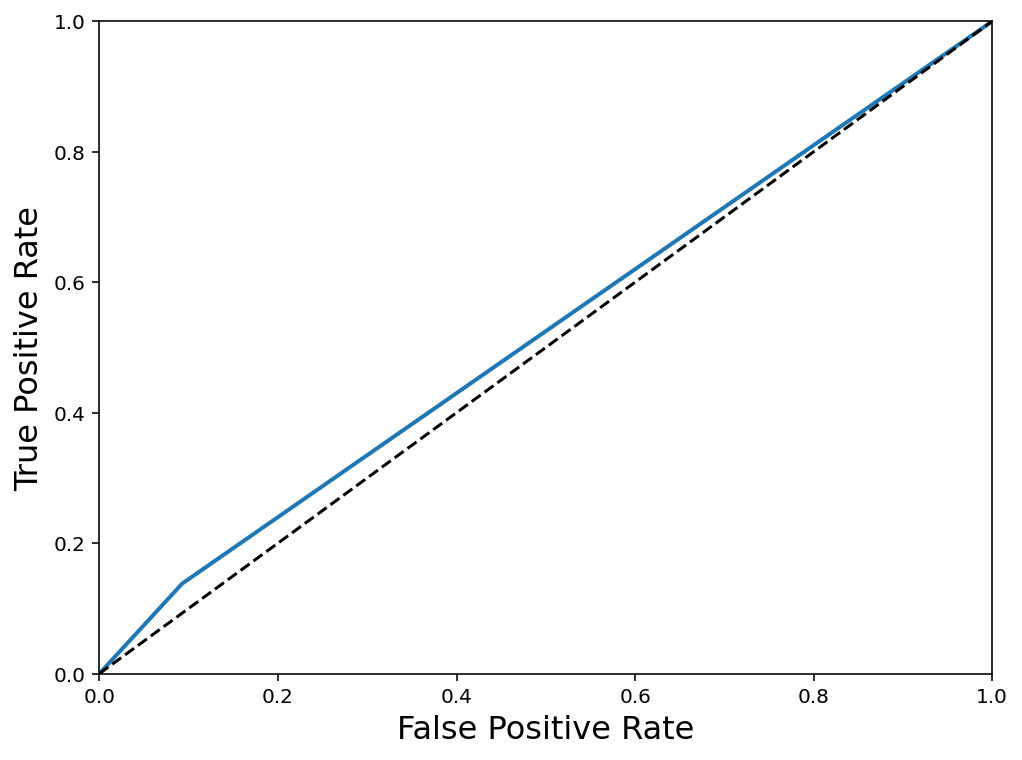

In [242]:
fpr,tpr,thresholds=roc_curve(y_test,y_pred_LR)

plt.figure(figsize=(8,6))
plot_roc_curve(fpr,tpr)

plt.show()

In [243]:
roc_auc_score(y_test,y_pred_LR)

0.5226206485438315

### 3.5 XGBoost
XGBoost (Extreme Gradient Boosting) is another ensemble model that utilizes boosting to turn a Decision Tree base-model into a strong learner. Ever since its introduction in 2014, it has been known for its consistently extraordinary performance. It is the most robust model and will be our final machine learning model. 

Contrary to Random Forest, a tree boosting model trains a new Decision Tree on the misclassified data points from the previous tree in a sequential manner. Or, it gives more weight for those instances that are misclassified by previous classifiers before training the subsequent one. Thus, each tree learns and improves from the previous one. Also, the more accurate classifiers are given more weight, and by aggregating the weighted average together, we usually obtain a better model and a better result. This process of sequential training on the residuals or errors, as commonly used by Gradient Boosting, is essentially using gradient descent to optimize the objective function and update the model. 

Boosting models have better handling of data of mixed type, more flexibility in optimizing different objective functions, and have higher predictive power. However, the disadvantages include more careful hyper-parameter tuning, computationally expensiveness, and less interpretability. 

But XGBoost is a better implementation of the normal Gradient Boosted Trees. XGBoost reduces execution speed through parallel and out-of-core computing and performs better than ordinary boosting models due to its scalability in all scenarios. It also introduces a regularization that controls the model's complexity and uses weighted quantile sketch to assign less weight to subsequent splits in a Decision Tree. (Chen, 2016) These improvements in XGBoost will help us avoid over-fitting and improve predictive power.


In [81]:
import xgboost as xgb

In [82]:
cv_params={
    'n_estimators':randint(low=50,high=500),
    'max_depth':randint(low=3,high=20),
    'learning_rate':[0.001,0.003,0.007,0.01,0.03,0.07,0.1],
    'min_child_weight':randint(low=1,high=10),
    'subsample':[0.5,0.6,0.7,0.8,0.9,1.0],
    'colsample_bytree':[0.5,0.6,0.7,0.8,0.9,1.0],
    'gamma':randint(low=0,high=10),
    'alpha':[0,1e-3,1e-2,0.1,1,10,100],
    'lambda':[1e-3,1e-2,0.1,1,5,10,50,100]
 }

ind_params={'seed':0,'objective':'binary:logistic','random_state':42,'n_jobs':-1}
RSCV_xgb=RandomizedSearchCV(xgb.XGBClassifier(**ind_params),
                           cv_params,n_iter=20,cv=5,scoring='accuracy')

In [0]:
RSCV_xgb.fit(X_train,y_train)  # Ran locally in another notebook

In [0]:
RSCV_xgb.cv_results_

In [0]:
RSCV_xgb.best_params_       
# {'alpha': 0.001,
# 'colsample_bytree': 0.7,
# 'gamma': 6,
# 'lambda': 0.01,
# 'learning_rate': 0.07,
# 'max_depth': 18,
# 'min_child_weight': 4,
# 'n_estimators': 209,
# 'subsample': 0.9}

In [0]:
RSCV_xgb.best_score_
# 0.8991055875752579

In [38]:
X_train=pd.read_csv("X_train.csv")
y_train=pd.read_csv("y_train.csv")
X_train=X_train.drop(['Unnamed: 0'],axis=1)
y_train=y_train.drop(['Unnamed: 0'],axis=1)
X_test=pd.read_csv("X_train.csv")
y_test=pd.read_csv("y_train.csv")
X_test=X_test.drop(['Unnamed: 0'],axis=1)
y_test=y_test.drop(['Unnamed: 0'],axis=1)

In [40]:
xgdmat=xgb.DMatrix(X_train,y_train)

Note: If we had more time, we can use early stopping to determine the best number of boost rounds. In fact, we would benefit with more num\_boost\_round. But due to the time constrait and slow cloud computation, we are not doing this :\)


In [45]:
our_params_xgb={'learning_rate':0.07,'seed':0,'subsample':0.9,'colsample_bytree':0.7,'gamma':6,
           'objective':'binary:logistic','max_depth':18,'min_child_weight':4,'alpha':0.001,'lambda':0.01,'n_jobs':-1}
final_xgb = xgb.train(our_params_xgb,xgdmat,num_boost_round=209)

In [47]:
importances_xgb = final_xgb.get_fscore()
importances_xgb
importance_frame=pd.DataFrame({'Importance':list(importances_xgb.values()),'Feature':list(importances_xgb.keys())})
importance_frame.sort_values(by='Importance',inplace=True)
importance_top=importance_frame.tail(10)
importance_top

,Importance,Feature
27,1055,number_emergency
24,1244,number_outpatient
23,1357,gender
1,2310,number_inpatient
17,2505,num_procedures
22,3054,number_diagnoses
31,3175,age
25,4360,time_in_hospital
20,8028,num_medications
15,11844,num_lab_procedures


importance_top.plot(kind='barh',x='Feature',figsize=(8,12),color='orange')

By analyzing the most important features of the XgBoost model, we found out that `number_emergency` and `number_outpatient` appears to be the most important features. This may due to the fact a higher number of emergency in the past indicates a higher risks of heavy diabete-related symptoms, hence increasing the possibility of getting readmitted for treatment within a short period (< 30 days). It's interesting to see that the number of outpatient visit has a slightly higher importance than the number of inpatient visit in the model, which is counterintuitive at first glance. This may suggest that we could have use the total number of visits to the hospital as a feature instead, since these two features have high correlation and both express the severity of the patient's diseases.

#### Performance



In [50]:
testdmat=xgb.DMatrix(X_test,y_test)
y_pred_xgb=final_xgb.predict(testdmat)
y_pred_xgb[y_pred_xgb>0.5]=1
y_pred_xgb[y_pred_xgb<=0.5]=0
y_pred_xgb

array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)

In [55]:
accuracy_score(y_test,y_pred_xgb)

0.9273970396615083

In [56]:
precision_score(y_test,y_pred_xgb)

0.9627633435315378

In [57]:
recall_score(y_test,y_pred_xgb)

0.8891849552728285

In [58]:
f1_score(y_test,y_pred_xgb)

0.9245125051375337

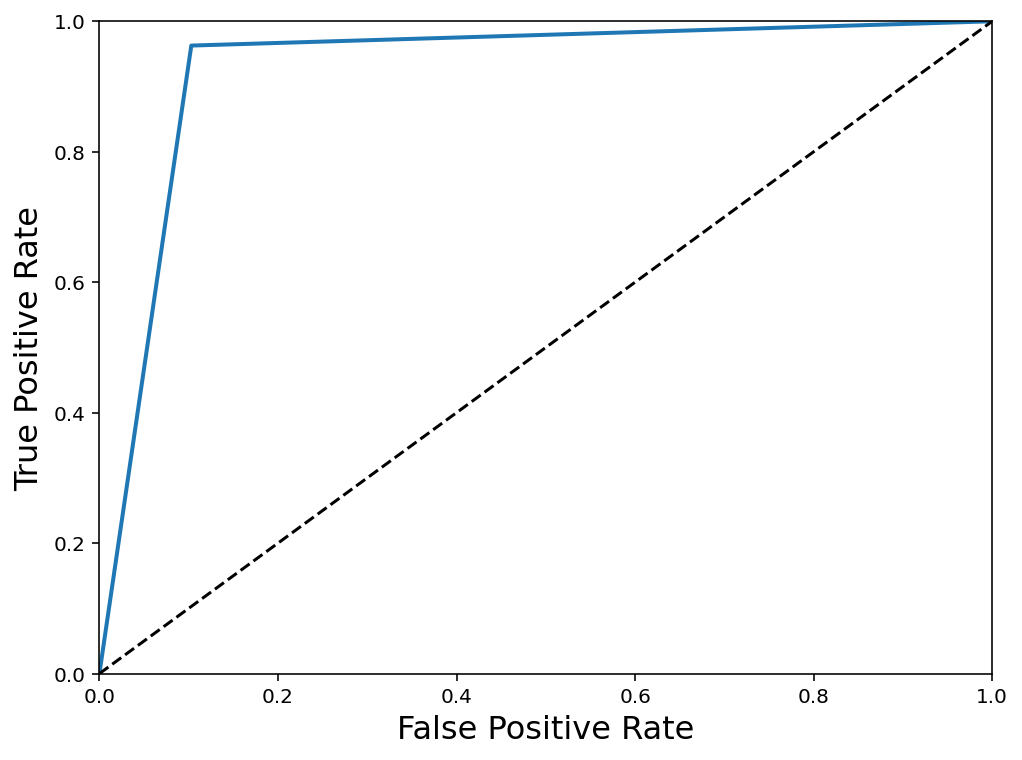

In [63]:
fpr,tpr,thresholds=roc_curve(y_pred_xgb,y_test)

plt.figure(figsize=(8,6))
plot_roc_curve(fpr,tpr)

plt.show()

In [64]:
roc_auc_score(y_pred_xgb,y_test)

0.9299079832601311

### 3.6 Performance Summary



|Model|Cross validation| Accuracy | Precision| Recall   |F1 Score |AUC|
|----------|----|----------|----------|------------------|---------|-----|
|Logistic Regression |86.3% | 81.9%| 16.2%|13.8%|0.149|0.523|
|Random Forest    |89.5% |83.8%|16.2%|13.8%|0.149| 0.523|
|XgBoost |89.9% |92.7%|96.2%|88.9%|0.925|0.930|



The low performance of the logistic regression and the random forest model may be subject to strong overfitting, which requires more careful model tuning to over the large set of categorical data in our database. In contrast, the XgBoost model achieves a high F1 score of 0.925 and doesn't appear to have overfitting issues.

## 4. Explanability
Once we have trained the final XGBoost model, we can use SHAP to explain the predictive results, which would be incredibly important in the healthcare sector. For the feature interaction values, a smaller balanced data set with 5000 entries randomly taken from the original data set is used. 

In the case of hospital readmission, understanding why the model makes a certain prediction is crucial. If the model were to be used in real life, individuals who go to the doctors will seek explanation -- ``why do I have such a high (or low) risk of being readmitted"? And in the case in which machine learning algorithms may be used to assist in decision making with regards to health resource assistance, it is vital that we understand the process. However, the highest accuracy for large modern data sets is often achieved by complex models such as XGBoost, creating a trade-off between accuracy and interpretability. (LundbergL, 2017) And so far, SHAP is one of the bests unified framework for interpreting predictions.

In essence, SHAP calculates \textit{shapley values}, which represents the feature importance by comparing what a model would predict with and without that feature. However, the order in which a model sees features can affect its predictions. SHAP thus calculates every possible coalitions and uses weighted sums to aggregate the feature importance. Take the feature ``gender" as an example, we can create different coalitions for all the other features and keep ``gender" (0 or 1) as the only independent variable. For each of these coalitions we compute the predicted 30-day readmission risk with and without the feature ``gender" and take the difference to obtain the marginal contribution. And the shapley value is the weighted average marginal contributions of a feature value across all possible coalitions.

By computing the shapley values for all possible features, we can obtain each feature's contribution to the final predictive decision. We would be able to produce a summary plot showing the most important predictors and how they contribute to the final decision. This would be important as we can explain which features are most likely to contribute to 30-day readmission and in which direction they contribute to the final decision. 

Furthermore, since we can evaluate the effect of features on individual data points, we will also be able to produce dependence plots and visualize the interactions between different features. The dependence plots are simply made from shapley values. And the interaction plots are made from shap interaction values, which can be interpreted as the difference between the shap values for feature $i$ when feature $j$ is present and the shap values for feature $i$ when feature $j$ is absent. (Lundberg, 2018) From these plots, we can draw some social implications and begin to discuss the existence of bias in real-life healthcare system.

Lastly, force plots can be made for explaining how an individual result was made. The plot explains how certain significant features increase the risk of readmission and by how much as well as how other features decrease the risk of readmission and by how much. Individual explanations are vitally important as readmission predictions are very individual-specific. Such plots would be beneficial for the implementation of this decision assistance tool as it will satisfy individual's queries and give him/her potential constructive medical advice.


In [34]:
import shap
shap.initjs()

In [65]:
shap_values_xgb=shap.TreeExplainer(final_xgb).shap_values(X_test) 

In [102]:
shap.summary_plot(shap_values_xgb,X_final,show=False)
plt.savefig('shapsummary.jpg',format='jpg',bbox_inches='tight',pad_inches=2,dpi=300)

NameError: name 'shap' is not defined

#### Individual Explanations



In [103]:
explainer_xgb=shap.TreeExplainer(final_xgb)

NameError: name 'shap' is not defined

In [0]:
y_proba_xgb_sorted=sorted(y_proba_xgb,reverse=True)
y_proba_xgb_sorted[0]

In [0]:
for i in range(len(y_proba_xgb)):
    if y_proba_xgb[i]>=y_proba_xgb_sorted[0]:
        print(i)

In [0]:
shap.force_plot(explainer_xgb.expected_value,shap_values_xgb[105196,:],X_test.iloc[105196,:],link="logit",show=False)

In [0]:
y_proba_xgb_sorted[-1]

In [0]:
for i in range(len(y_proba_xgb)):
    if y_proba_xgb[i]<=y_proba_xgb_sorted[-1]:
        print(i)

In [0]:
shap.force_plot(explainer_xgb.expected_value,shap_values_xgb[21581,:],X_LTU_unscaled.iloc[21581,:],link="logit",show=True)